# Lecture 10 — Bayesian Statistical Inference: III

[Open this notebook in Google Colab](https://colab.research.google.com/github/daanmeerburg/Statistics_meerburg_2026//blob/main/Lectures/Lecture_10_PDM.ipynb)


**Lecturer:** P. D. Meerburg 

*Heavily based on materials by Davide Gerosa (astroML, 2022) and collaborators. See [here](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/README.md) for credits.*

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.

##### For those who want to dive deep:

- [MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki.
- [The Metropolis-Hastings algorithm](https://arxiv.org/abs/1504.01896) by Christian P. Robert.
- [Sampler, Samplers, Everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) by Matt Pitkin.
- [MCMC Interactive Demo](https://chi-feng.github.io/mcmc-demo/app.html) by Chi Feng.



___



>## Monte Carlo Methods & Markov Chains <a class="anchor" id="one"></a>

### Motivation

Consider the problem of estimating location and scale parameters for homoscedastic data drawn from a Gaussian distribution that we looked at in `Lecture_8`. We had a two-dimensional posterior pdf for $\mu$ and $\sigma$:

![Ivezic, Figure 5.5](http://www.astroml.org/_images/fig_likelihood_gaussian_1.png)

It was easy to *numerically* integrate the posterior pdf to find the marginal distributions, and find its maximum, using a brute-force grid search because it was only a 2D problem. With $100$ grid points per coordinate it was only $10^4$ values. 

However, **what about high parameter dimensions?**
- Even in a case of rather simple 5D problem (as we'll discuss later today), we'd have $10^{10}$ values! And often we work with models of much higer dimensionality (it can be thousands!). **Brute-force grid methods are not feasible beyond a few dimensions**, and even then can be waste of time. 
- You could **simply randomly sample the grid at every point**, and try to find the minimum based on that. But that can also be quite time consuming, and you will spend a lot of time in regions of parameter space that yields small likelihood.

A better way is to adopt a ***Markov-Chain Monte Carlo (MCMC)***. MCMC gives us a way to make this problem computationally tractable by sampling the full multi-dimensional parameter space, in a way that builds up the most sample density in regions that are closest to the maximum probability. Then, you can post-process the “chain” of points to infer the posterior distribution and uncertainty regions.

Ivezic, Figure 5.22 shows a problem similar to the one above, done with a Markov Chain Monte Carlo algorithm.  The dashed lines are the known (analytic) solution.  The solid lines are from the MCMC estimate with 10,000 sample points.

![Ivezic, Figure 5.10](http://www.astroml.org/_images/fig_cauchy_mcmc_1.png)

### What does Monte Carlo mean?

We've seen Monte Carlo integrations already. The name derives from the name of an administrative area of the Principality of Monaco ([Monte Carlo](https://www.wikiwand.com/en/Monte_Carlo)) known for high-stakes casinos and gambling. Gambling and random sampling go hand in hand together.

![](https://www.thomascook.com/.imaging/mte/thomascook-theme/og-image/dam/legacy/heros/citybreaks/monte-carlo/montecarlohero.jpg/jcr:content/montecarlohero.jpg)

**Example you've probably seen already: compute $\pi$** 
- You have forgotten the value of $\pi$, but you know the formula for the area of a square and how to draw a circle. 
- We can use the information that we *do* know to numerically compute $\pi$.

1. We start by drawing a square and circumscribing a circle in it (actually it suffices to just do a quarter of a circle and scale accordingly).
2. We put down random points within the square and note which ones land in the circle.
3. The ratio of random points in the circle to the number of random points drawn is related to the area of our circle, allowing us to calculate $\pi$.
4. Using more random points yields more precise estimates of the area.

Try it below. How many draws does it take to get the error down to 1 part in a thousand?

We'll consider one quadrant of a square of sides [-1,1] in which we inscribe a circle (actually just one quarter of a circle).

In [1]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Estimate of pi is 3.124 for 10000 draws with fractional error 0.005599915561837868.


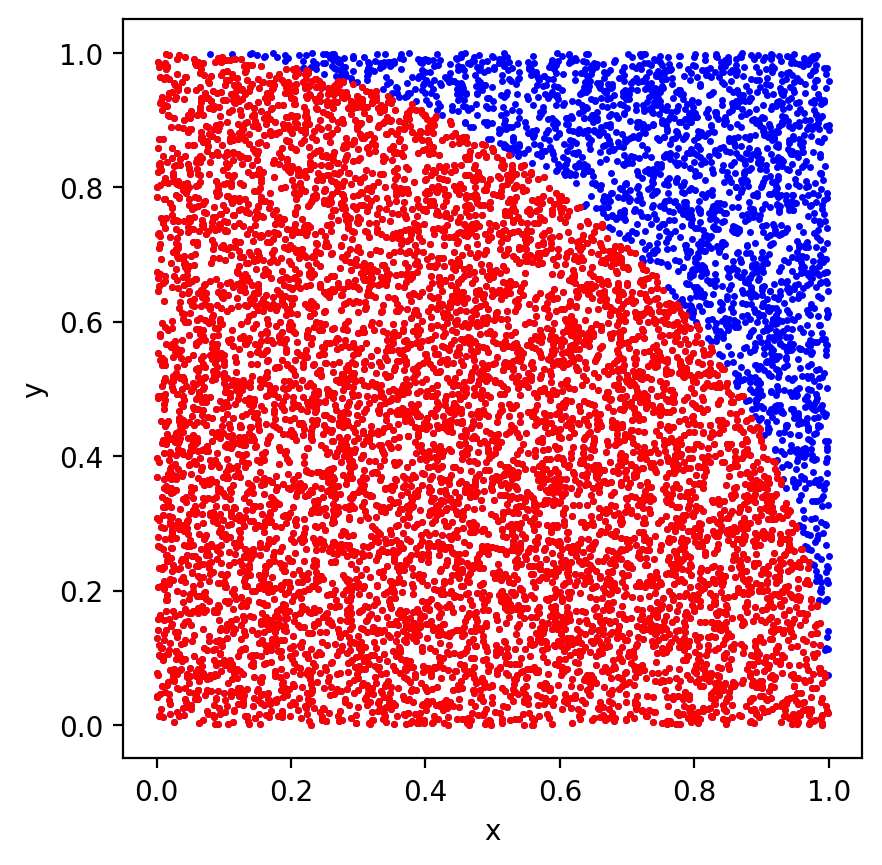

In [3]:
# Lay down M random points.  Tally how many are within a unit circle.
M = 10000
x = stats.uniform(0,1).rvs(M) # M random draws between 0 and 1
y = stats.uniform(0,1).rvs(M) # M random draws between 0 and 1

r2 = x**2+y**2 # equation for radius of cirle in x,y

#note that he maximum size sphere radius is 1 (because x and y are between 0 and 1). 

# Set up figure
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))

# Plot points in square
plt.plot(x, y, '.', 
         markersize=3, c='blue') 

# Plot points also in circle
plt.plot(x[r2 < 1], y[r2 < 1], '.', 
         markersize=3, c='red') 

#ax.axis([0, 1, 0, 1], aspect='equal');
plt.xlabel('x')
plt.ylabel('y')
    
# A_square = d^2, A_circle = pi*d^2
piEst = 4 * np.sum(r2 < 1) / M # pi = A_circle/A_square = 4A/d^2, where A is d^2 times the ratio of points "in" to total points

print("Estimate of pi is {0} for {1} draws with fractional error {2}.".format(piEst, M, 
                                                                              np.abs((np.pi-piEst)/np.pi)))

See also [this Khan Academy simulation](https://www.khanacademy.org/python-program/approximating-pi/6544702023254016).

#### Try at home: 
Generalize the code above to compute the volume of an N-dimensional sphere as a function of the number of dimension $N$. Warning: the $N\to\infty$ limit is very surprising. Here is a blog post about this funny math problem: https://davidegerosa.com/nsphere/. Note that this is pretty advanced and not part of the course. 


### Back to buisiness...


- In general, ***Monte Carlo methods*** use random sampling to obtain a numerical result (e.g., the value of an integral), where there is no analytic result or it is difficult to obtain.
- In the case of the circle above, we have computed the intergral: $\int\int_{x^2+y^2\le 1} dx dy.$

Recall ***Monte Carlo integration***. 
- Our goal was to integrate $\int g(x)f(x)dx$. 
- We could do this on a grid of $x$, such that $\int g(x)f(x)dx \approx \sum_{i=1}^N g(x_i)f(x_i)\Delta x$, where we use the probability distribution at each grid point $f(x_i)$ as weights for the sum over $g(x_i)$.
- But we might waste terms in the sum over low probability areas. If we have random draws from $f(x)$ then the *density* of those points in $x$ directly represent the weighting we desire. We will get most weight in regions of high probability. 
- We can think of our random samples as $f(x)$ being a sum of $\delta$ functions at the sampled points, all overlapping to give high density at the high probability regions. The integral is then 

$$ \int g(x)f(x)dx \approx \frac{1}{N}\int g(x)\sum_i^N\delta(x_i)dx = \frac{1}{N}\sum_i^N \int g(x)\delta(x_i)dx = \frac{1}{N}\sum_i^N g(x_i).$$

>## What is a Markov Chain?

A Markov Chain is defined as 

> a sequence of random variables where a parameter depends *only* on the preceding value. Such processes are "memoryless".  
 
Mathematically, we have

$$p(\theta_{i+1}|\theta_i, \theta_{i-1}, \theta_{i-2}, \cdots) = p(\theta_{i+1}|\theta_i).$$

For  equilibrium, or a stationary distribution of positions, it is necessary that the transition probability is symmetric:

$$    p(\theta_{i+1}|\,\theta_i) = p(\theta_i |\, \theta_{i+1}). $$

This is called the ***principle of detailed balance*** or reversibility condition (i.e. the probability of a jump between two points does not depend on the direction of the jump).


For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would a  Markov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)


>## Markov Chain Monte Carlo (MCMC) Techniques <a class="anchor" id="two"></a>

> The use of **Markov chains** to perform **Monte Carlo integration** is called ***Markov Chain Monte Carlo (MCMC)***.

Given such a Markov chain of length $N$ that corresponds to draws of $p(\theta)$, integrals can be estimated as

$$ \int g(\theta) \, p(\theta) \, d\theta \approx {1 \over N} \sum_{i=1}^Ng(\theta_i).$$

- To estimate the expectation value for $\theta_1$ (i.e., $g(\theta)=\theta_1$), we simply take the mean value of all $\theta_1$ in the chain.
- To visualize the posterior pdf for parameter $\theta_1$, marginalized over all other parameters, $\theta_2, \ldots, \theta_k$, we can construct a histogram of all $\theta_1$ values in the chain, and normalize its integral
to 1. 
- To get a MAP (*maximum a posterori*) estimate for $\theta_1$, we find the maximum of this marginalized pdf.

In order for a Markov chain to reach a **stationary distribution** proportional to $p(\theta)$, the probability of arriving at a point $\theta_{i+1}$ must be proportional to $p(\theta_{i+1})$,

$$ p(\theta_{i+1}) = \int  T(\theta_{i+1}|\theta_i)  \,   p(\theta_i) \,    d \theta_i, $$

where the transition probability $T(\theta_{i+1}|\theta_i)$ is called the **proposal distribution** (and it is assumed that we know how to compute $p(\theta_i)$). The proposal distribution is exactly what it sounds like-- it proposes new positions to jump to in parameter space.

This requirement will be satisfied when the transition probability satisfies **the principle of detailed balance**

$$ T(\theta_{i+1}|\theta_i)  \,  p(\theta_i) = T(\theta_i|\theta_{i+1})  \,  p(\theta_{i+1}). $$

Most of the difficulty in MCMC comes from either determining the burn-in or deciding how to step from one position to another.  In our $\pi$ circle example above, we drew points in a completely random manner. However, that's sub-optimal. ***We want random sampling that preferentially steps into regions of high probability density.***  



>## Markov Chain Monte Carlo (MCMC) Techniques <a class="anchor" id="two"></a>

> The use of **Markov chains** to perform **Monte Carlo integration** is called ***Markov Chain Monte Carlo (MCMC)***.

In many realistic problems, especially in cosmology and particle physics, we are
interested in integrals of the form

$$
\int g(\theta)\, p(\theta)\, d\theta,
$$

where $p(\theta)$ is a posterior probability distribution over one or more
parameters $\theta = (\theta_1,\ldots,\theta_k)$.  
In more than a few dimensions, these integrals are often impossible to compute
analytically and prohibitively expensive to evaluate using simple grid methods.

**Monte Carlo integration** provides a powerful alternative. If we can generate
samples $\{\theta_i\}_{i=1}^N$ drawn from the distribution \(p(\theta)\), then
integrals can be approximated as simple averages:

$$
\int g(\theta)\, p(\theta)\, d\theta
\;\approx\;
\frac{1}{N}\sum_{i=1}^N g(\theta_i).
$$

This approximation becomes exact in the limit of large $N$.

---

### What does an MCMC chain represent?

A **Markov Chain Monte Carlo (MCMC)** algorithm constructs a sequence of samples

$$
\theta_1, \theta_2, \ldots, \theta_N
$$

such that, after an initial transient phase, the samples are distributed
according to the target distribution $p(\theta)$.

Once we have such a chain:

- The expectation value of any parameter (e.g. $\theta_1$ is estimated by
  taking the mean of its values along the chain).
- The **marginalized posterior** for a parameter (e.g. $\theta_1$) is obtained
  by constructing a histogram (or KDE) of all $\theta_1$ values and normalizing
  it to integrate to 1.
- A **MAP (maximum a posteriori)** estimate is obtained by locating the maximum
  of this marginalized posterior.

Importantly, MCMC does *not* require us to know the normalization of $p(\theta)$;
it only requires the ability to evaluate it up to a constant factor.

---

### Why a Markov chain?

The samples generated by MCMC are **not independent**. Instead, each new sample
depends only on the previous one:

$$
\theta_{i+1} \sim T(\theta_{i+1}\mid\theta_i),
$$

where $T(\theta_{i+1}\mid\theta_i)$ is the **transition probability** or
**proposal distribution**. This property — that the next state depends only on
the current state — defines a *Markov chain*.

The goal is to choose $T$ such that, after many steps, the chain reaches a
**stationary distribution** equal to the desired target distribution:

$$
p(\theta_{i+1})
=
\int T(\theta_{i+1}\mid\theta_i)\, p(\theta_i)\, d\theta_i.
$$

---

### Detailed balance and stationarity

A sufficient (but not strictly necessary) condition for the chain to converge to
the correct stationary distribution is the principle of **detailed balance**:

$$
T(\theta_{i+1}\mid\theta_i)\, p(\theta_i)
=
T(\theta_i\mid\theta_{i+1})\, p(\theta_{i+1}).
$$

This condition guarantees that the probability flow between any two points in
parameter space is balanced, so that $p(\theta)$ remains unchanged under the
dynamics of the chain.

Many common MCMC algorithms, including the Metropolis–Hastings algorithm, are
explicitly constructed to satisfy detailed balance.

---

### Why not sample completely at random?

In earlier Monte Carlo examples (e.g. estimating $\pi$ by throwing random
points in a square), points were drawn **uniformly** over the entire space.
This becomes extremely inefficient in high-dimensional problems, where most of
the volume lies in regions of negligible probability.

The key idea behind MCMC is therefore:

> **Sample preferentially from regions where the probability density is high.**

By proposing new points based on the current position and accepting or rejecting
them according to $p(\theta)$, MCMC algorithms spend most of their time
exploring the regions of parameter space that actually matter for inference.

---

### Practical challenges

In practice, most of the difficulty in MCMC comes from:

- **Burn-in**: determining how many initial samples must be discarded before the
  chain reaches its stationary distribution.
- **Proposal tuning**: choosing step sizes and proposal shapes that efficiently
  explore parameter space without getting stuck or random-walking too slowly.
- **Diagnosing convergence**: deciding whether the chain has run long enough to
  accurately represent the posterior.

These issues will become clear through concrete examples and hands-on use of
MCMC algorithms in the following sections.


The most commonly used algorithm for stepping from one position to another is the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm.  

>## The Metropolis-Hastings Algorithm <a class="anchor" id="three"></a>

**The Metropolis-Hastings algorithm** adopts the following acceptance probability for newly proposed points to step to:

$$ p_{\rm acc}(\theta_i,\theta_{i+1}) = { p(\theta_{i+1}) \over p(\theta_i) }, $$

where the proposed point $\theta_{i+1}$ is drawn from an *arbitrary* symmetric density distribution $T(\theta_{i+1}\,|\,\theta_i)$. Since it is symmetric, the **ratio of transition probabilities cancels out and detailed balance is ensured**. A Gaussian distribution centered on the current point $\theta_i$ is often used for $T(\theta_{i+1}|\theta_i)$.

This algorithm guarantees that the chain will reach an equilibrium, or stationary, distribution, and it will approximate a sample drawn from $p(\theta)$! 

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1. Given $\theta_i$ and $T(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$ 
2. Compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.
3. Draw a random number between 0 and 1 from a uniform distribution; if it is smaller than $p_{\rm acc}(\theta_i,\theta_{i+1})$, then accept $\theta_{i+1}$. 
4. ***If $\theta_{i+1}$ is accepted added it to the chain. If not, add $\theta_{i}$ to the chain.***
5. Use the chain (of $\theta$ values) for inference; e.g. a histogram of $\theta$ is an estimator of the posterior pdf for $\theta$, $p(\theta)$, and the expectation value for $\theta$ can be computed from 

  $$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{N} \sum_{i=1}^N g(\theta_i).$$

where N is the number of elements in the chain (e.g. the expectation value for $\theta$ is simply the mean value of chain elements). 

***Step 4*** is very important. If we only accepted points of higher probability then we would only move up the posterior density to find its maximum. But we want to map out the full posterior density, so sometimes we must settle for less!

>## Corner Plots

When using MCMC, we typically work with **multiple parameters**. Even for a
moderate number of dimensions, it quickly becomes impossible to visualize the
full posterior distribution directly. A standard solution is therefore to look
at **two parameters at a time**, marginalizing over all others.

The resulting visualizations are known as **corner plots** (or **triangle
plots**). Each diagonal panel shows the **1D marginalized posterior** for a
single parameter, while the off-diagonal panels show **2D joint posteriors**
revealing correlations and degeneracies between parameter pairs. An example is
shown in Ivezic et al., Figure 5.24, where the results of fitting a single
Gaussian model are compared to a double-Gaussian model.

Corner plots are a standard diagnostic tool in cosmology, particle physics, and
gravitational-wave astronomy, and are often the first thing inspected after an
MCMC run.

---

### Commonly used corner-plot packages

The most widely used and actively maintained packages today are:

- **[`corner`](https://corner.readthedocs.io/en/latest/):**  
  The de facto standard for visualizing posterior samples. It is lightweight,
  well-maintained, and designed specifically for MCMC and Bayesian inference.
  It supports contours, quantiles and truth markers.

- **[`ChainConsumer`](https://samreay.github.io/ChainConsumer/):**  
  A higher-level visualization and analysis tool that can combine multiple
  chains, overlay models, and compute summary statistics. It is especially
  popular in cosmology, where comparing posteriors from different datasets or
  models is common.

- **[`GetDist`](https://getdist.readthedocs.io/):**  
  A long-standing and widely used package in cosmology (especially in the
  **CosmoMC / CAMB** ecosystem) for analysing Monte Carlo samples and producing
  triangle plots. This is the package I am most familar with. It is actively
  documented and maintained, and includes extensive plotting utilities beyond
  just corner plots. :contentReference[oaicite:2]{index=2}


In the past, other tools were also used. For example, [`scotchcorner`](https://github.com/mattpitkin/scotchcorner) provided elegant
corner plots and was widely adopted in gravitational-wave astronomy, but it is no longer actively maintained and is therefore not recommended for new projects.


>## Worked Example <a class="anchor" id="four"></a>

Let's now go through the worked example from
[http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/).

Let's generate some data points and plot them.  We'll try a normal distribution, centered at 0 with 100 data points, using [numpy.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html). Our goal is to estimate $\mu$.

Text(0, 0.5, 'data density')

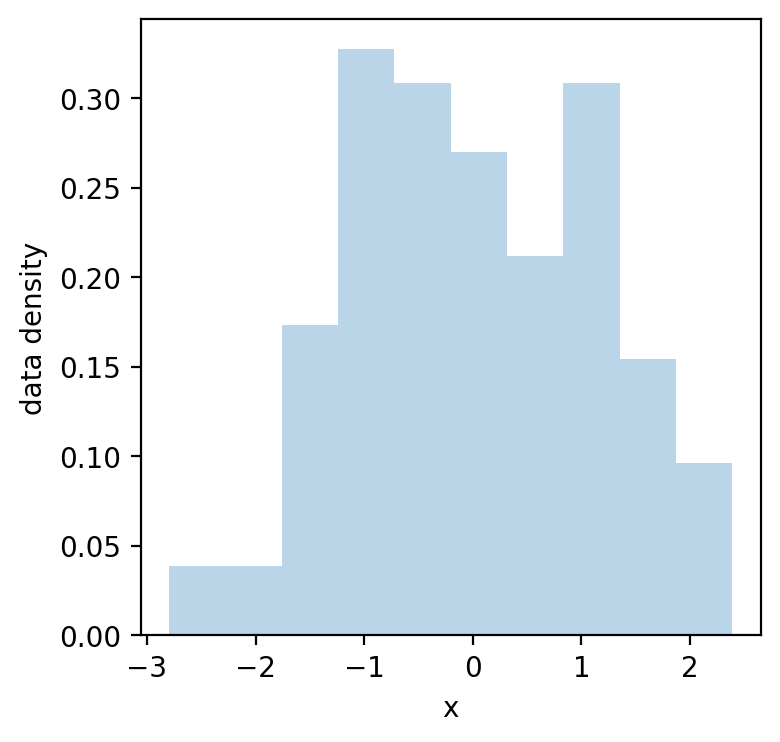

In [4]:
import scipy as sp
import pandas as pd
from scipy.stats import norm

# Plot a histogram of random numbers drawn from a normal distribution
np.random.seed(123)

data = np.random.randn(100)
plt.figure(figsize=(4,4))
plt.hist(data, bins=10, density=True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('data density')

Now we have to pick a model.

- We'll assume a Gaussian likelihood distribution: $\mathscr{N}(\mu,\sigma=1)$ (i.e., with $\sigma=1$).  
- We'll also assume a Gaussian distribution for the prior on $\mu$: $\mathscr{N}(0,1)$.

We can use that to write an analytic function for our posterior distribution as follows (*recalling that the product of two Gaussians is also a Gaussian as we mentioned in lecture 8*. 

Before using MCMC, it is useful to recall a case where the posterior can be
derived analytically. This will serve as a benchmark for our numerical results.

We assume:
- data $\{x_i\}_{i=1}^n$ drawn from a Gaussian with known variance $\sigma^2$,
- a Gaussian prior on the mean $\mu$.

The likelihood is

$$
p(\{x_i\}\mid\mu)
=
\prod_{i=1}^n
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\!\left[-\frac{(x_i-\mu)^2}{2\sigma^2}\right],
$$

and the prior is

$$
p(\mu)
=
\frac{1}{\sqrt{2\pi\sigma_0^2}}
\exp\!\left[-\frac{(\mu-\mu_0)^2}{2\sigma_0^2}\right].
$$

By Bayes’ theorem,

$$
p(\mu\mid\{x_i\}) \propto p(\{x_i\}\mid\mu)\,p(\mu).
$$

Taking the logarithm and keeping only terms that depend on $\mu$, we obtain

$$
\ln p(\mu\mid\{x_i\})
=
-\frac{1}{2}
\left[
\frac{n}{\sigma^2}(\mu-\bar{x})^2
+
\frac{1}{\sigma_0^2}(\mu-\mu_0)^2
\right]
+ \text{constant},
$$

where $\bar{x}$ is the sample mean.

This expression is quadratic in $\mu$, so the posterior must be Gaussian.
Completing the square gives

$$
p(\mu\mid\{x_i\})
=
\mathcal{N}(\mu_{\rm post},\,\sigma_{\rm post}^2),
$$

with

$$
\sigma_{\rm post}^2 =
\left(\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1},
\qquad
\mu_{\rm post} =
\sigma_{\rm post}^2
\left(
\frac{\mu_0}{\sigma_0^2} + \frac{\sum_i x_i}{\sigma^2}
\right).
$$

These expressions will be used below as a reference when validating our MCMC
results.

---

Rather than working with variances, it is often clearer to work with **precisions**, defined as the inverse variance:

$$
\tau \equiv \frac{1}{\sigma^2},
\qquad
\tau_0 \equiv \frac{1}{\sigma_0^2}.
$$

In terms of precisions, the posterior precision is simply the sum of the prior
and data precisions:

$$
\tau_{\rm post}
=
\tau_0 + n\,\tau
=
\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}.
$$

This gives the posterior variance

$$
\sigma_{\rm post}^2
=
\left(
\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}
\right)^{-1}.
$$


The posterior mean is a **precision-weighted average** of the prior mean and the
sample mean:

$$
\mu_{\rm post}
=
\sigma_{\rm post}^2
\left(
\frac{\mu_0}{\sigma_0^2}
+
\frac{\sum_{i=1}^n x_i}{\sigma^2}
\right).
$$


Text(0, 0.5, 'post probability density')

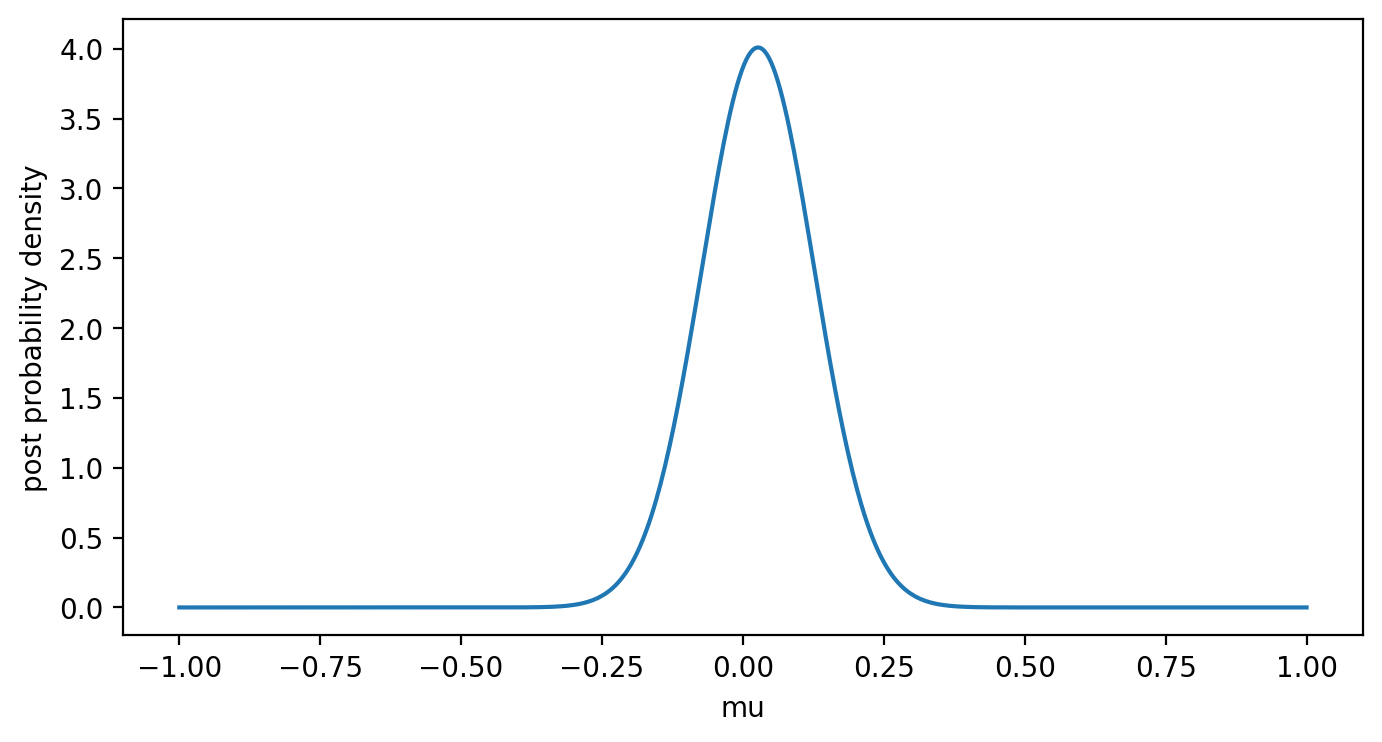

In [6]:
# Execute this cell
def calc_posterior_analytical(data, xgrid, mu_0, sigma_0):
    sigma = 1. # known error on data points
    # Number of data points
    n = len(data)
    
    # Error-weighted sum of prior and average of data
    # Recall the product of 2 Gaussians
    
    # This is the Gaussian for the prior: mu_0 / sigma_0**2
    # This is the Gaussian for the likelihood: data.sum() / sigma**2
    # We are deriving the mean from the sum of the data values
    
    #postior mean and variance based on equations we derived above
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    var_post = (1. / sigma_0**2 + n / sigma**2)**-1
    
    return norm.pdf(xgrid, mu_post, np.sqrt(var_post))

plt.figure(figsize=(8,4))
xgrid = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, xgrid, 0., 1.)
plt.plot(xgrid, posterior_analytical)
plt.xlabel('mu')
plt.ylabel('post probability density')

Let's try this instead with MCMC. 

- We'll start with a trial $\mu_0 = -1$ and evaluate.
- Then we'll jump to a new position using the Metropolis-Hastings algorithm mentioned above.  
- Next we evaluate whether that jump was "good" or not -- by seeing if the value of the likelihood $\times$ prior increases.  

*We always work with the un-normalized posterior (i.e. likelihood $\times$ prior) in these MCMC algorithms (or equivalently the un-normalized log-posterior which equals log-likelihood + log-prior).*

The first function below is an implementation of the Metropolis-Hastings algorithm. Please study this code carefully to understand the steps. 

In [8]:
## Execute this cell
## See https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.ipynb
def sampler(data, samples=4, mu_init=.5, proposal_width=0.5, 
            plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        # changing the width of this distribution changes how big the jump is between trials.
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        # Compute posterior probability (unnormalized)
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        # Accept if p_accept > 1 (since random limited to [0,1]) and if p_accept > rand as well
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, 
                          mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        # Append to posterior trace (sometimes referred to as "chain"). 
        posterior.append(mu_current)
        
    return posterior

## Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, 
                  mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    xgrid = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm.pdf(xgrid,mu_prior_mu, mu_prior_sd)
    ax1.plot(xgrid, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', 
            title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, 
                                                                                       prior_current, 
                                                                                       mu_proposal, 
                                                                                       prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm.pdf(xgrid,loc=mu_proposal, scale=1)
    
    ax2.hist(data,alpha=0.5,density='True')
    ax2.plot(xgrid, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 
                                                                              1e14*likelihood_current, 
                                                                              mu_proposal, 
                                                                              1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, xgrid, 
                                                     mu_prior_mu, 
                                                     mu_prior_sd)
    ax3.plot(xgrid, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, 
                                                  mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, 
                                                   mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, 
                                                                            posterior_current, 
                                                                            mu_proposal, 
                                                                            posterior_proposal)) 
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

Each row below is a single iteration through our Metropolis-Hastings sampler.

- **1st column = prior distribution**. The distribution is static and we are only plugging in our $\mu$ proposals. The vertical lines represent the current $\mu$ in blue and the proposed $\mu$ in either red or green (rejected or accepted, respectively).


- **2nd column = likelihood**.  The likelihood function changes in response to the proposed $\mu$. The blue histogram is the data. The solid line in green or red is the likelihood with the currently proposed mu. The more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dashed line of the same color is the proposed mu and the dashed blue line is the current mu.


- **3rd column = (normalized) posterior distribution**.


- **4th column = trace** (i.e. the posterior samples of $\mu$ we are generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values. More precisely, in the Metropolis–Hastings algorithm we propose a new value
$\mu'$ and compute the acceptance probability

$$
\alpha = \min\!\left(1,\; \frac{p(\mu' \mid D)}{p(\mu \mid D)} \right).
$$

- If $p(\mu' \mid D) > p(\mu \mid D)$, then $\alpha = 1$ and the move is always
  accepted.
- If $p(\mu' \mid D) < p(\mu \mid D)$, then $\alpha < 1$ and the move is accepted
  only with probability $\alpha$.

This rule ensures that the Markov chain spends more time in regions of high
posterior probability, while still occasionally visiting regions of lower
probability to maintain detailed balance and ensure convergence to the correct
stationary distribution.

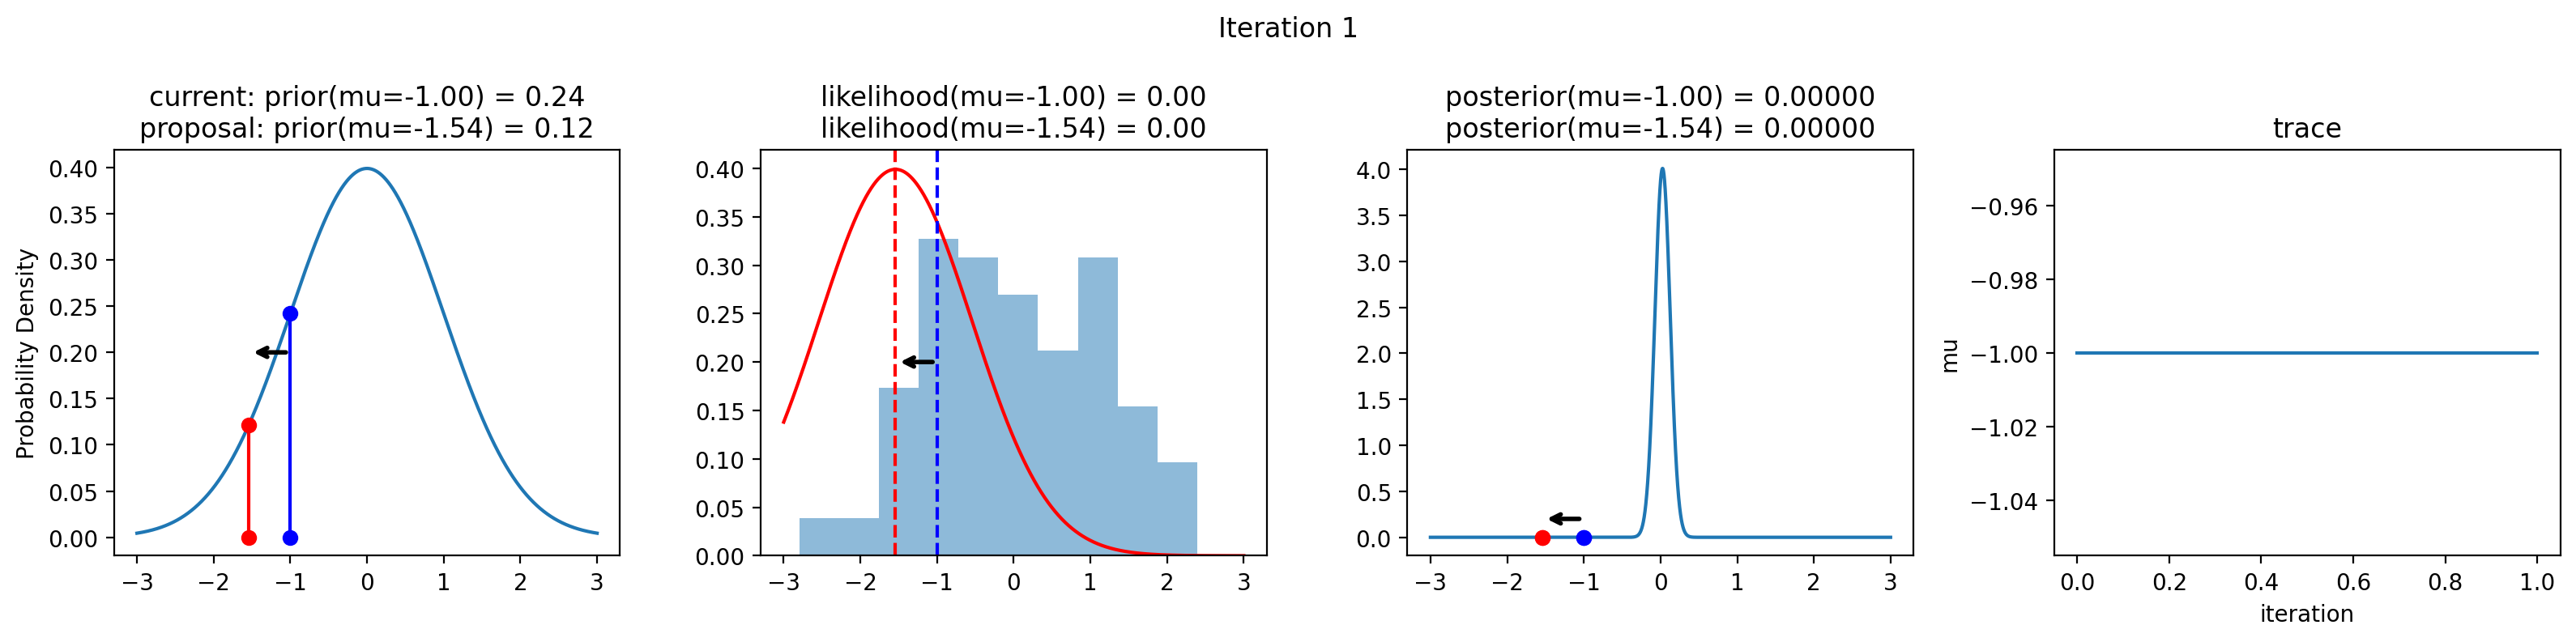

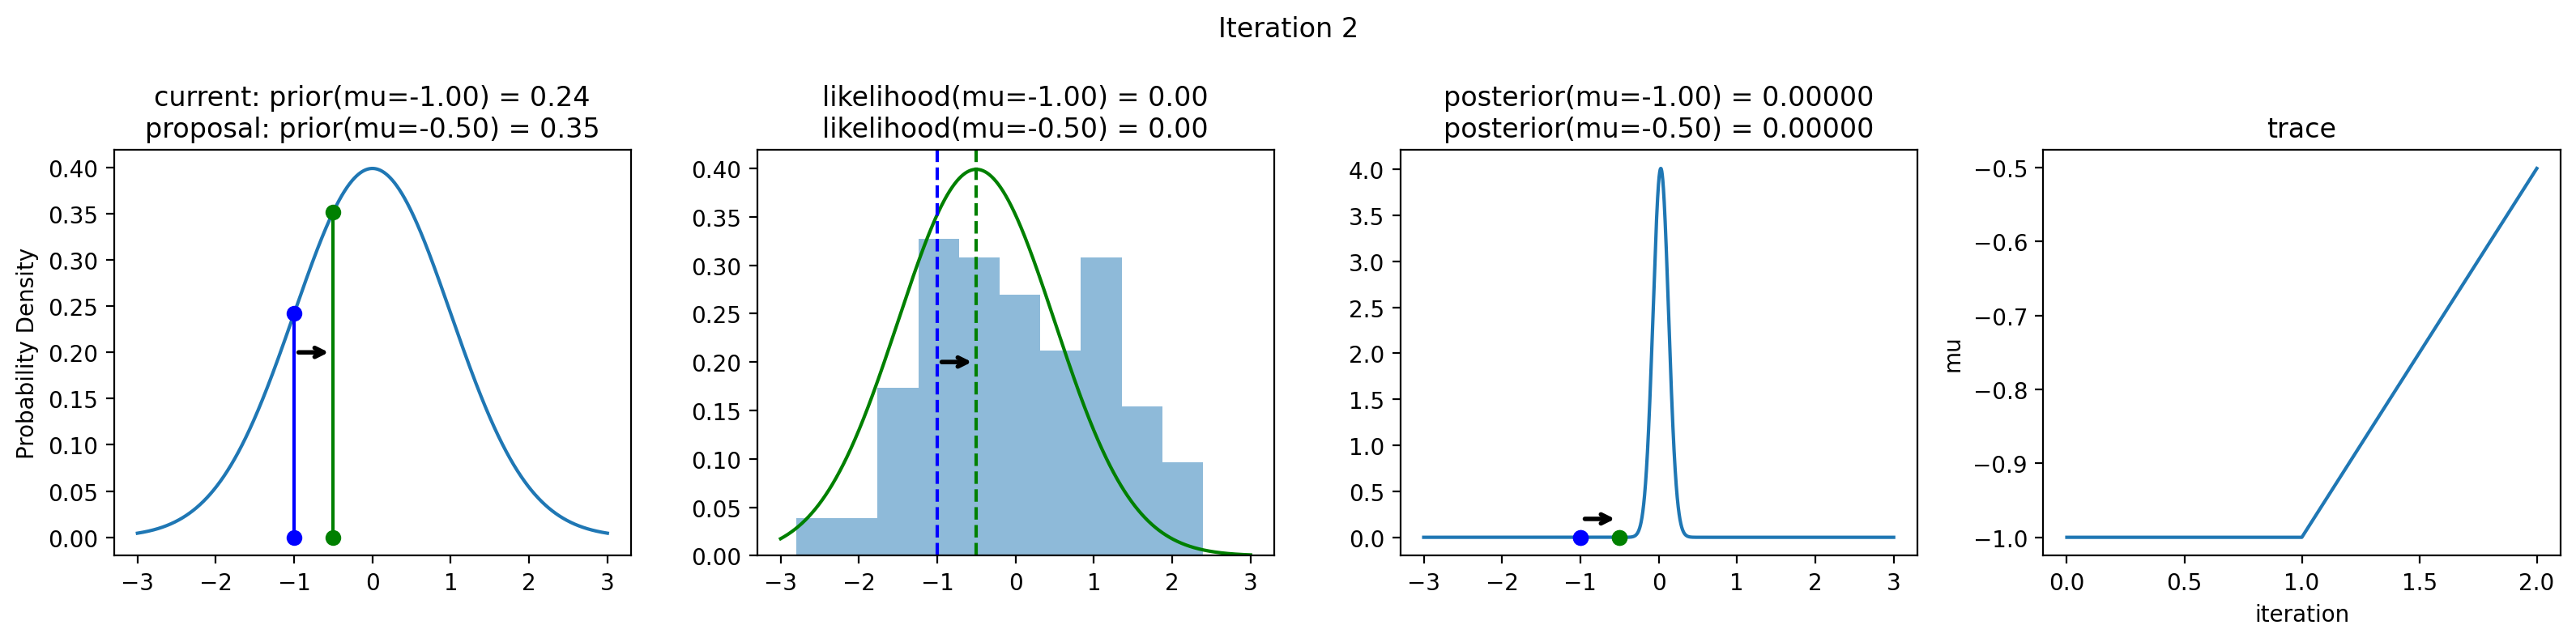

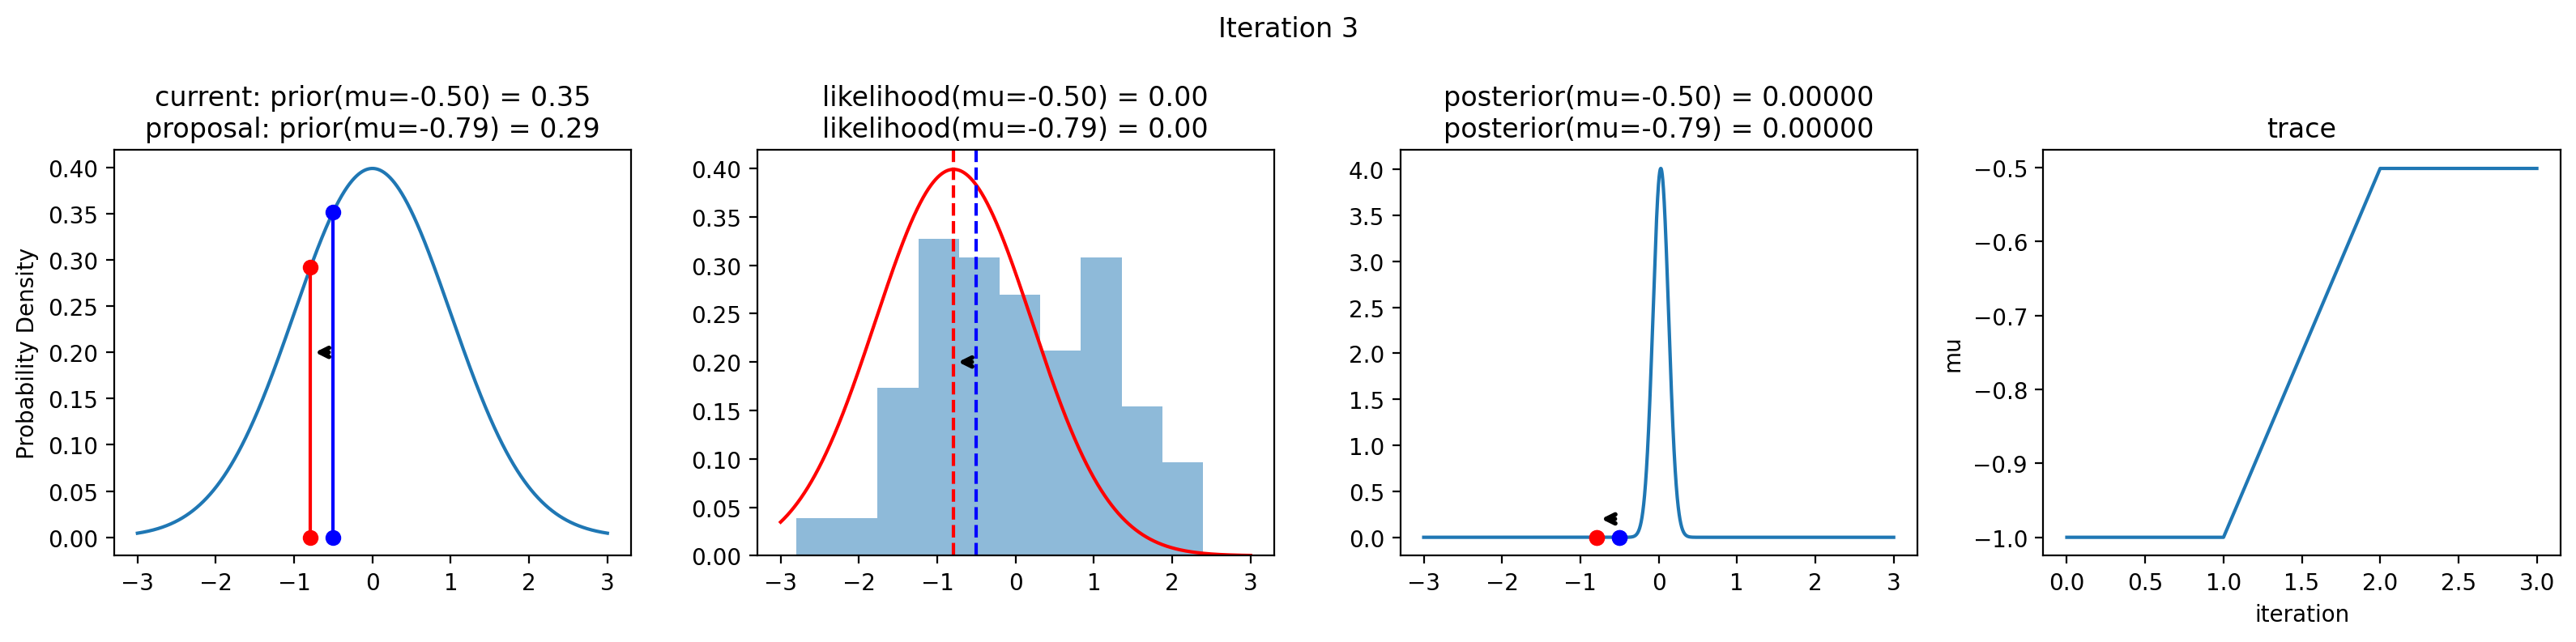

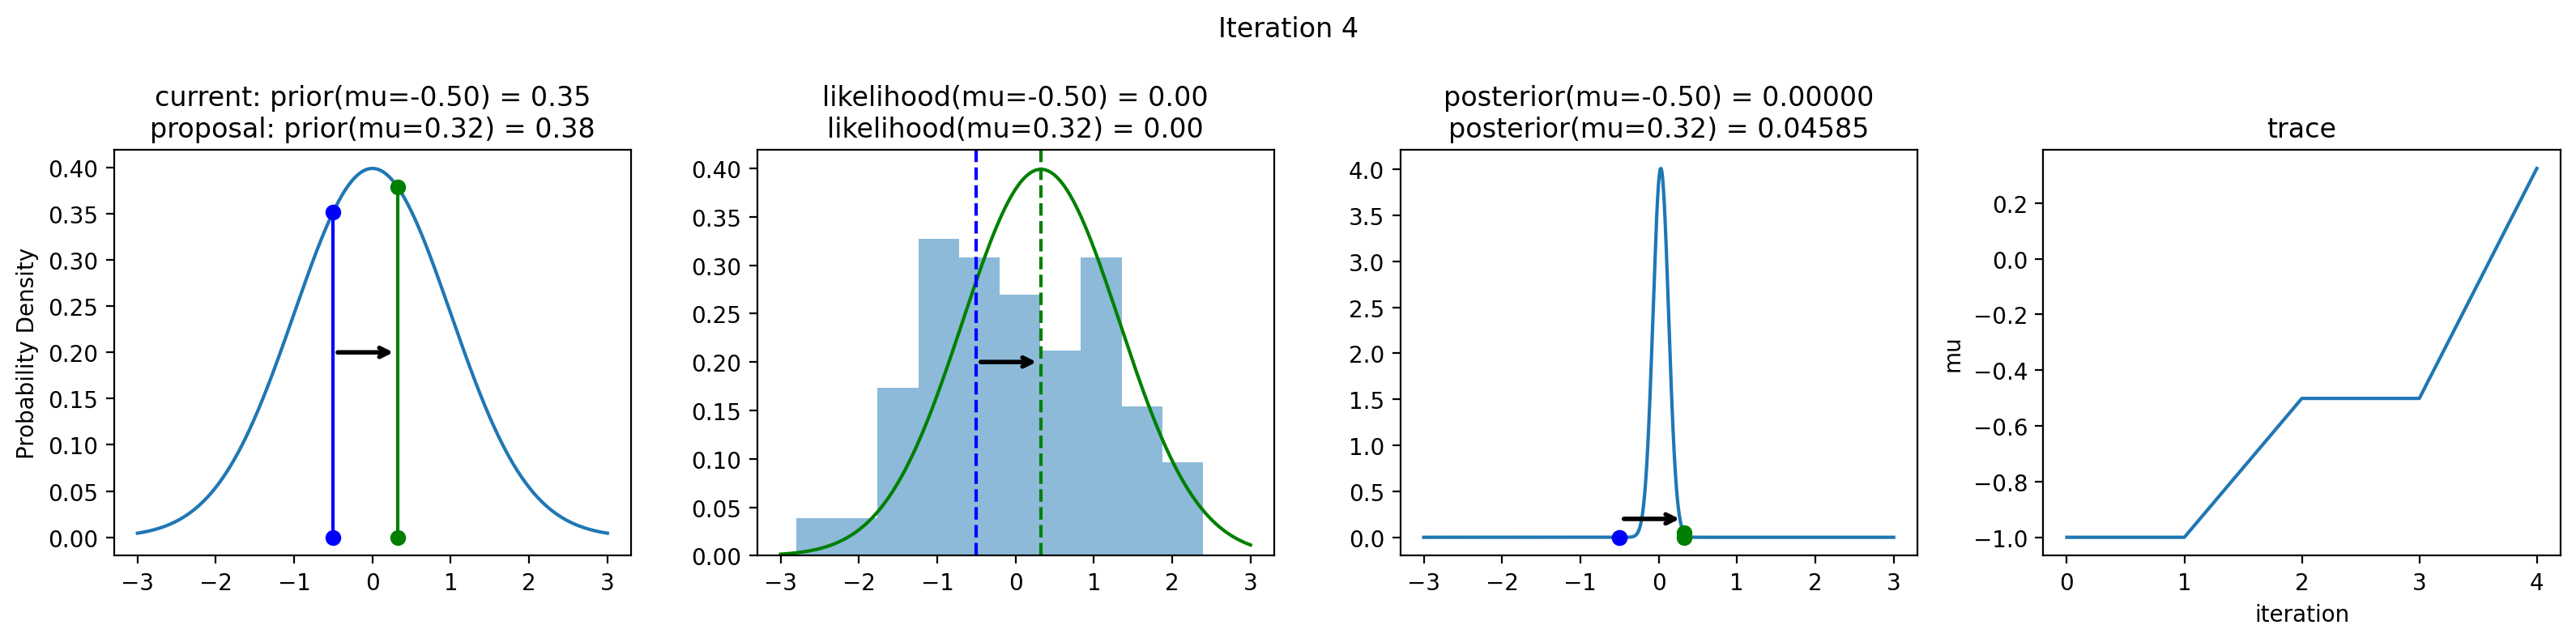

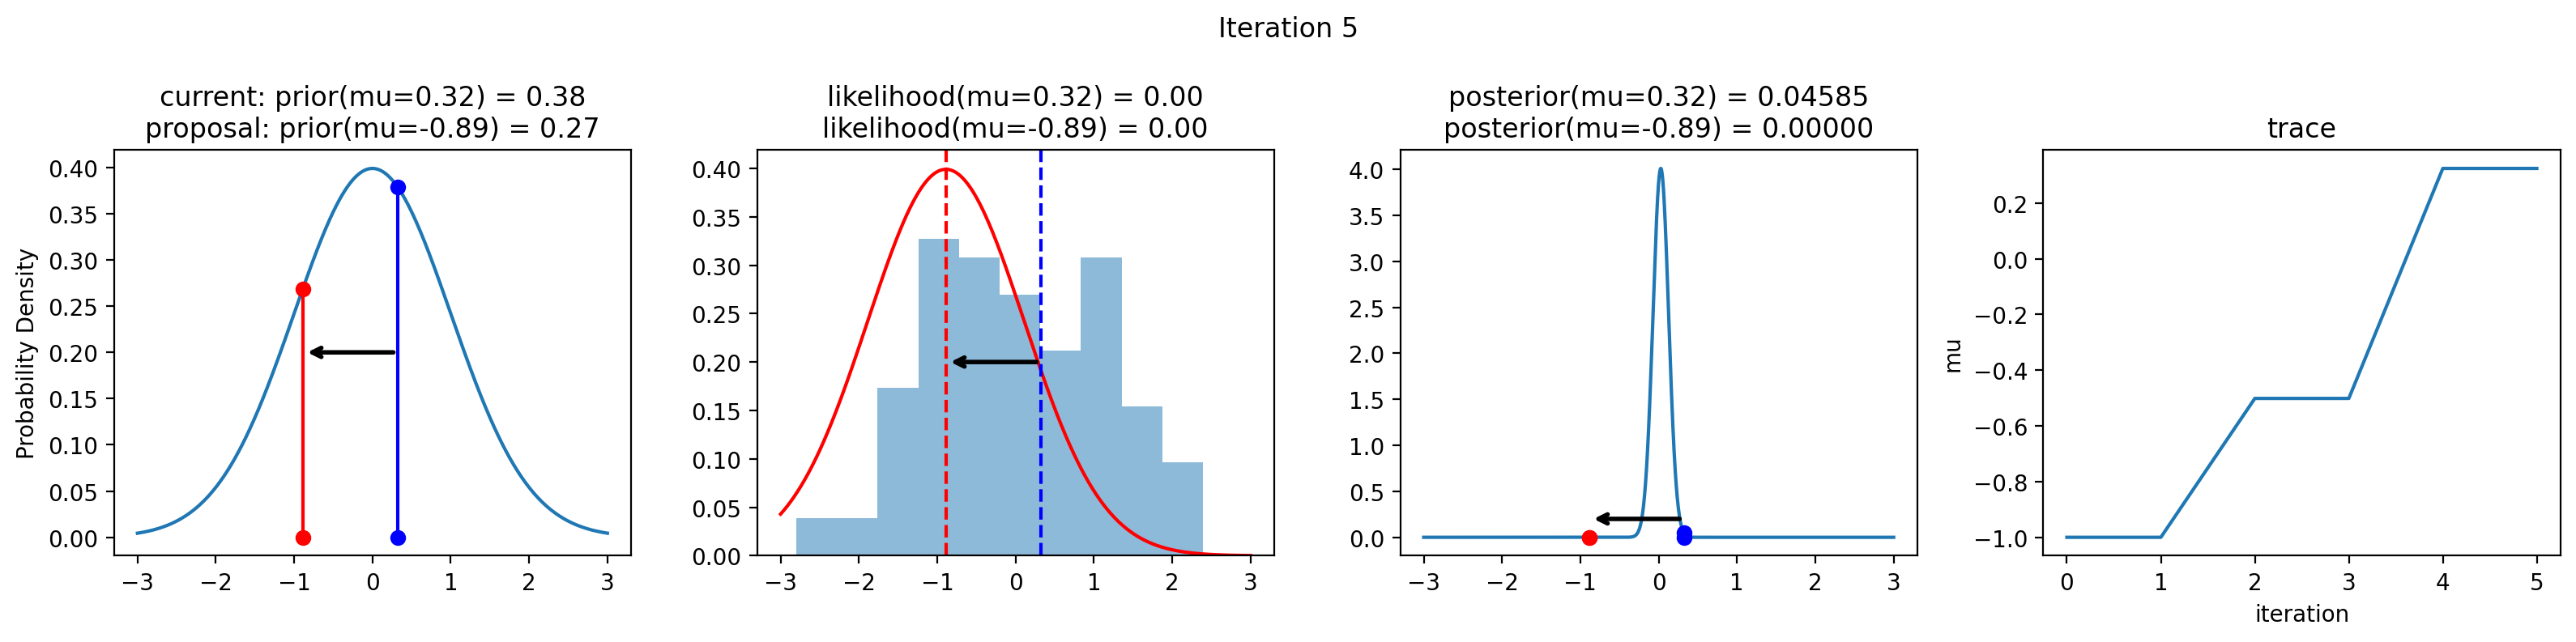

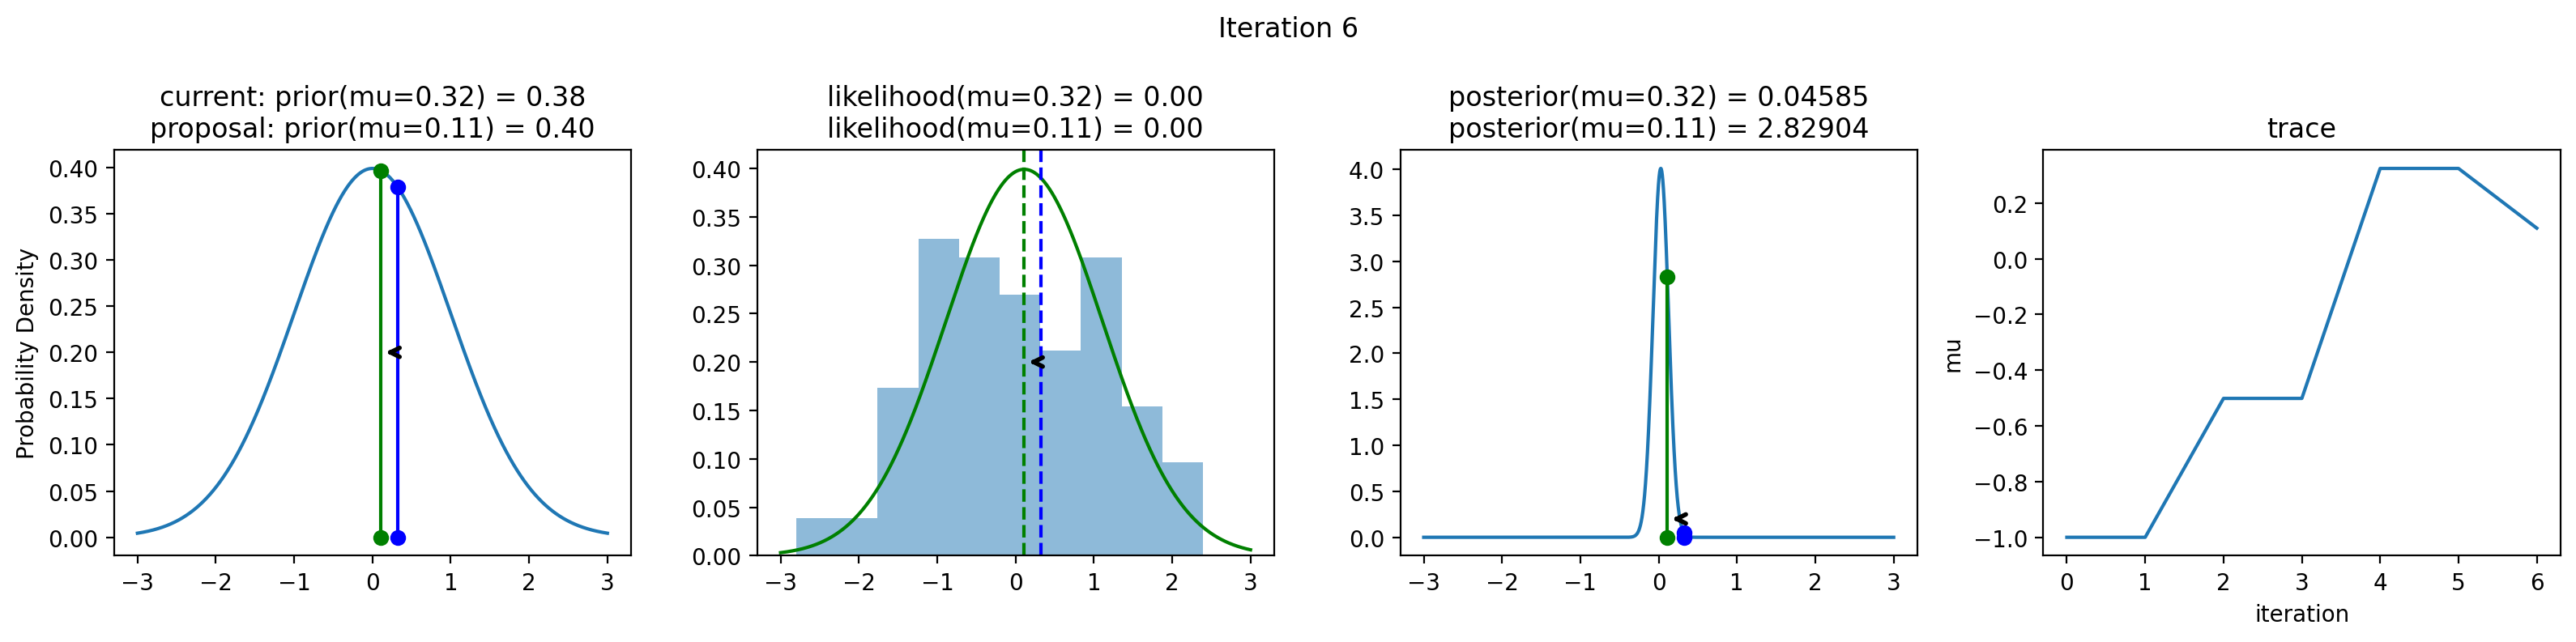

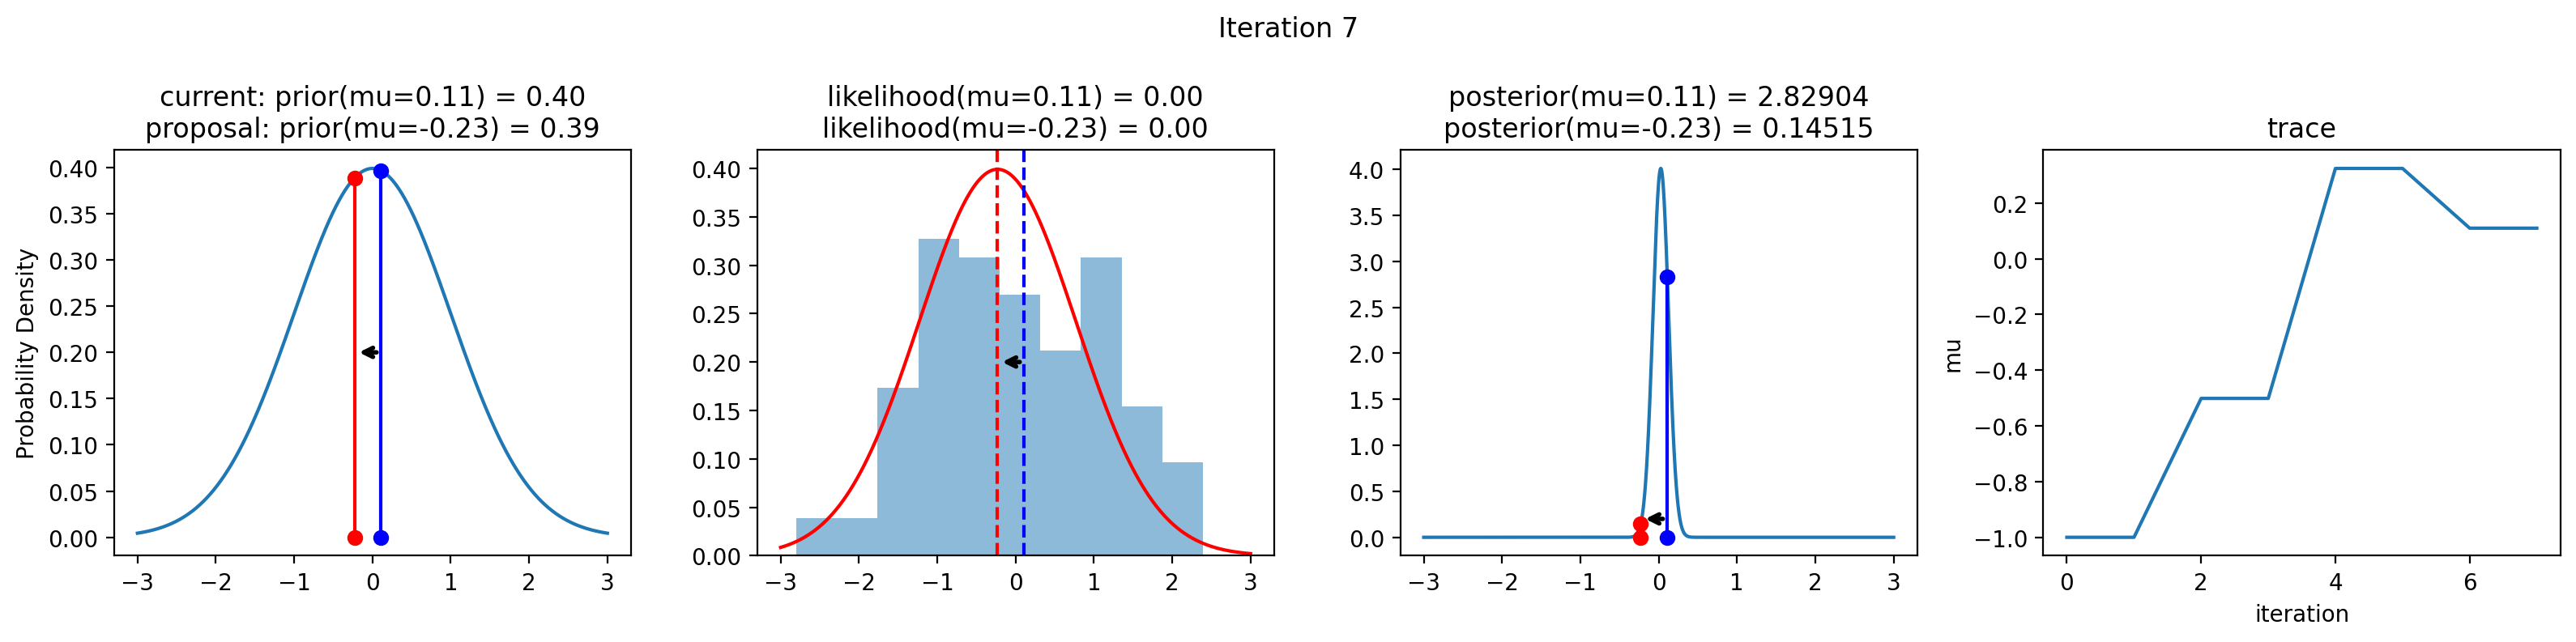

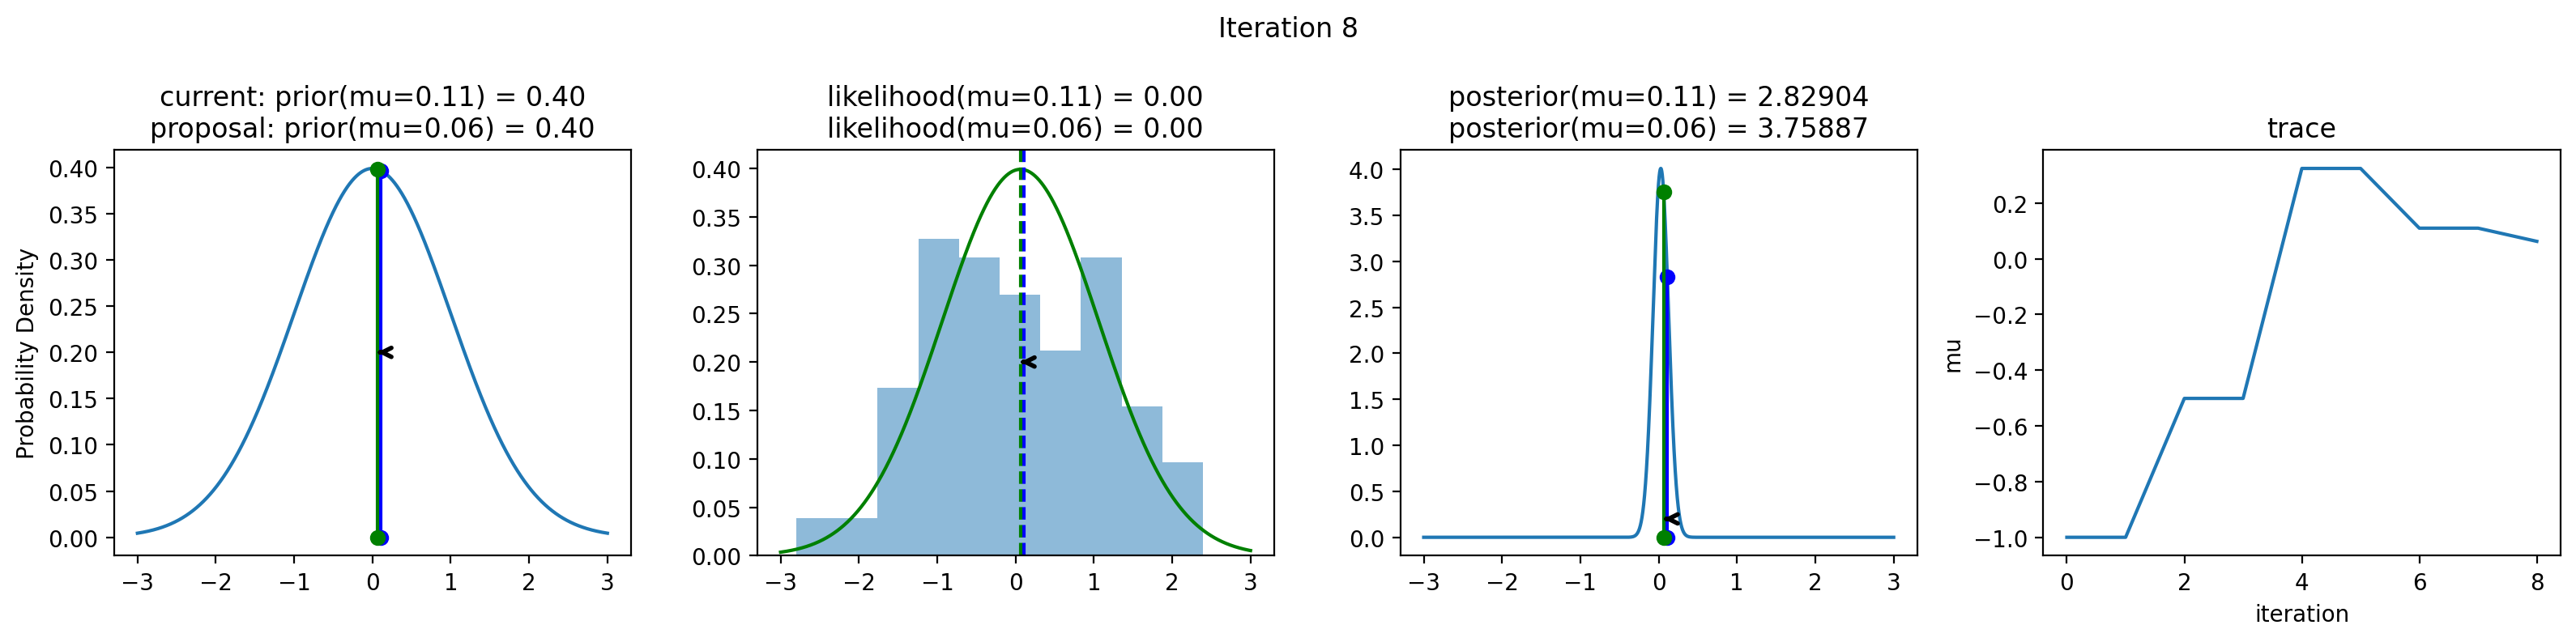

In [9]:
#we fix the random seed for reproducibility
np.random.seed(123)
#we take 8 samples from the posterior, starting at mu=-1: 
samples = sampler(data, samples=8, mu_init=-1., plot=True);

What happens when we do this lots of times? You might need to wait for a minute. Consider this a lesson in that running MCMCs can sometimes feel like watching paint dry.

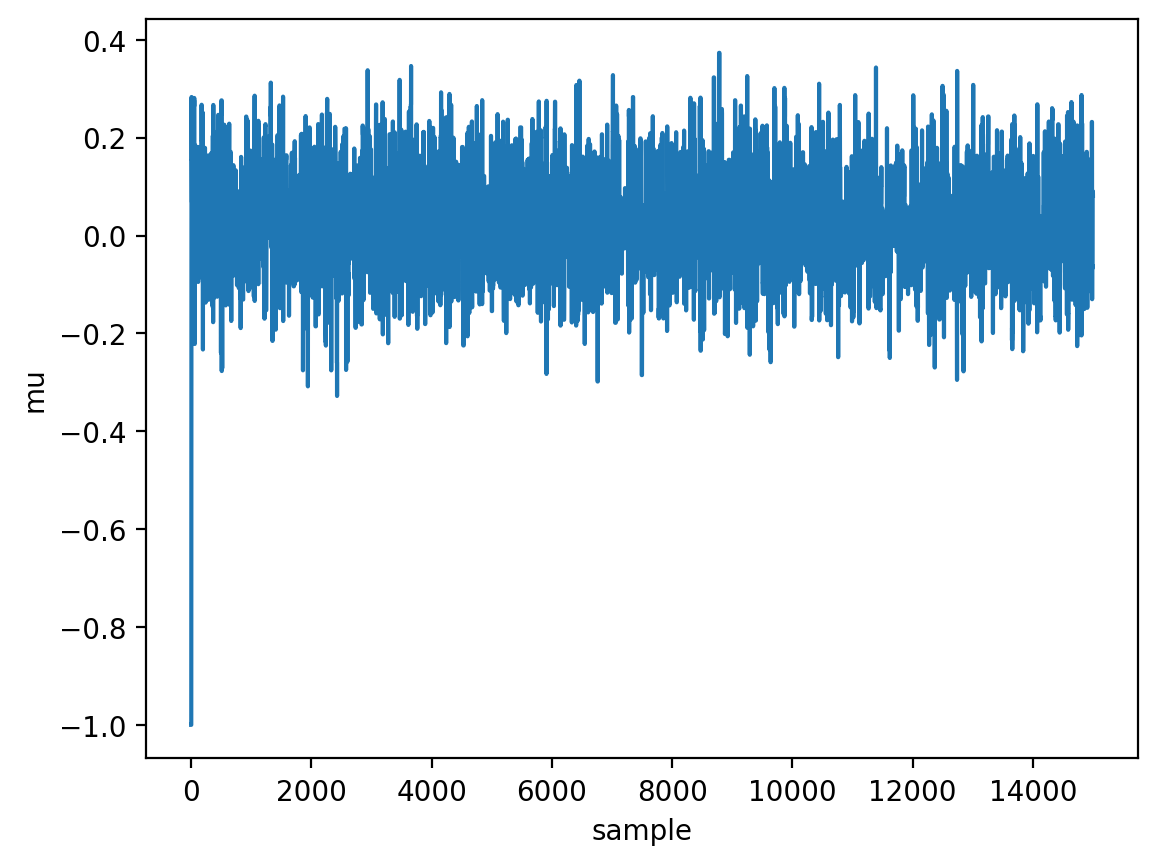

In [10]:
posterior = sampler(data, samples=15000, mu_init=-1.) #making sure we are not plotting here!
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

What's happening at the beginning? That depends on our initial proposal, which is bad. One always needs to remove some samples at the beginning. This is called **"burn in"**.

Making a histogram of these results is our estimated posterior probability distribution. Let's remove the first $500$ points as burn-in.

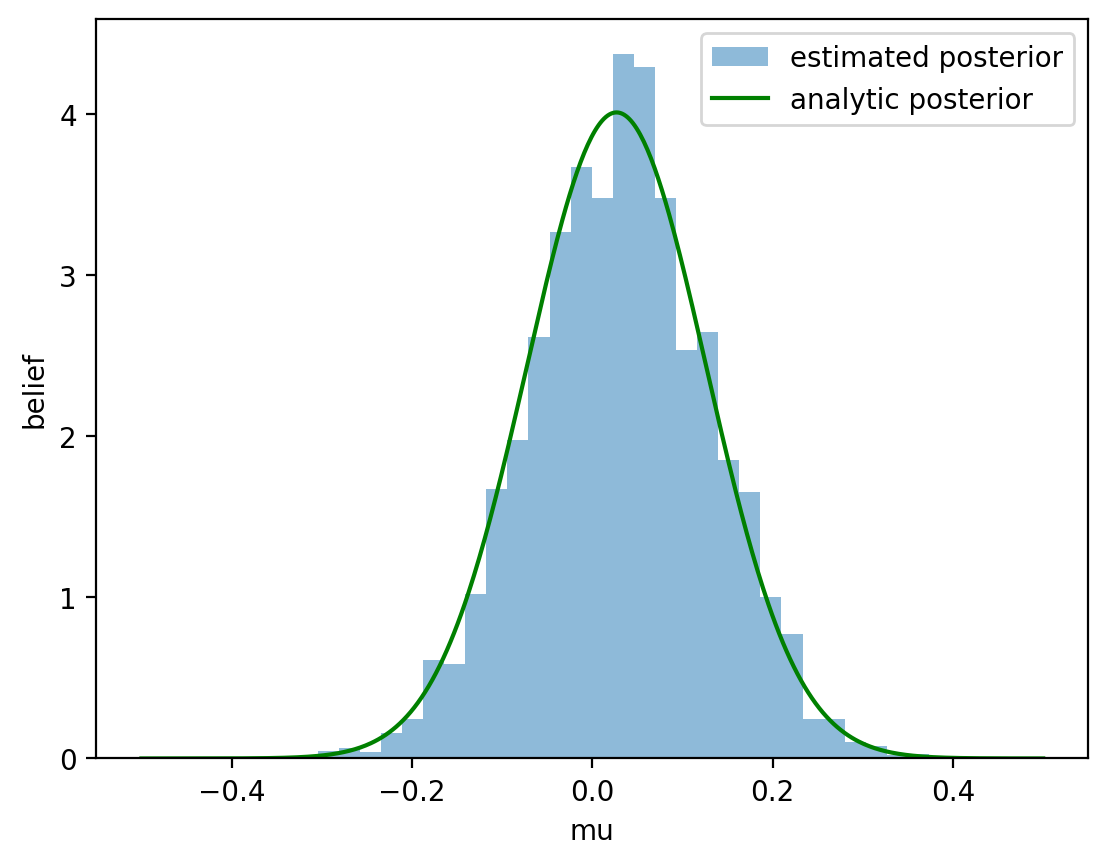

In [11]:
ax = plt.subplot()

burn = 500
ax.hist(posterior[burn:], bins=30, alpha=0.5, 
        density='True', label='estimated posterior')

xplot = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, xplot, 0, 1)
ax.plot(xplot, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');

ax.legend(fontsize=10);

We can compute the expected value of $\mu$, credible regions, and the MAP value.

Reminder: **MAP** stands for **Maximum A Posteriori**.

The MAP estimate is the value of a parameter (or set of parameters) that
*maximizes the posterior probability density*,

$$
\theta_{\rm MAP}
=
\arg\max_{\theta}\, p(\theta \mid D).
$$

In words: it is the most probable parameter value *after* combining the data
(likelihood) with prior information.

In [16]:
# expected value
ex_mu = np.mean(posterior[burn:])

# 68% equal-tailed credible region, i.e., 16th and 84th percentiles (about 1 sigma for a Gaussian)
lower, upper = np.percentile(posterior[burn:],q=16), np.percentile(posterior[burn:],q=84)   

# MAP value
# many samplers output the likelihood x prior, 
# so a good way to estimate the MAP is to histogram the posterior samples
hist, bins = np.histogram(posterior[burn:], bins=100)
# and then compute bin midpoints
bin_mid = 0.5 * (bins[1:] + bins[:-1])
# index of max value in histogram
idx = np.argsort(hist)[-1]
# max value of theta at that index
map_theta = bin_mid[idx]

print('Expected value of mu = ' + str(ex_mu))
print('68% credible region = ' + str(lower) + ' to ' + str(upper))
print('MAP value = ' + str(map_theta))

Expected value of mu = 0.031654096125402834
68% credible region = -0.06622887192725768 to 0.13205416681847315
MAP value = 0.040268114159831864


In [21]:
#ALternatively, we can use kernel density estimation to get a smooth estimate of the posterior density
from scipy.stats import gaussian_kde
#convert to numpy array for use in gaussian_kde
x = np.asarray(posterior[burn:])
kde = gaussian_kde(x)
grid = np.linspace(x.min(), x.max(), 2000)
map_theta = grid[np.argmax(kde(grid))]
print('MAP value = ' + str(map_theta))

MAP value = -0.7743768396030022


Our algorithm for deciding where to move next used a normal distribution where the mean was the current value and we assumed a width of 0.5. Let's make this much smaller and much larger and see what it does to the sampling efficiency through the behavior of the traceplot.

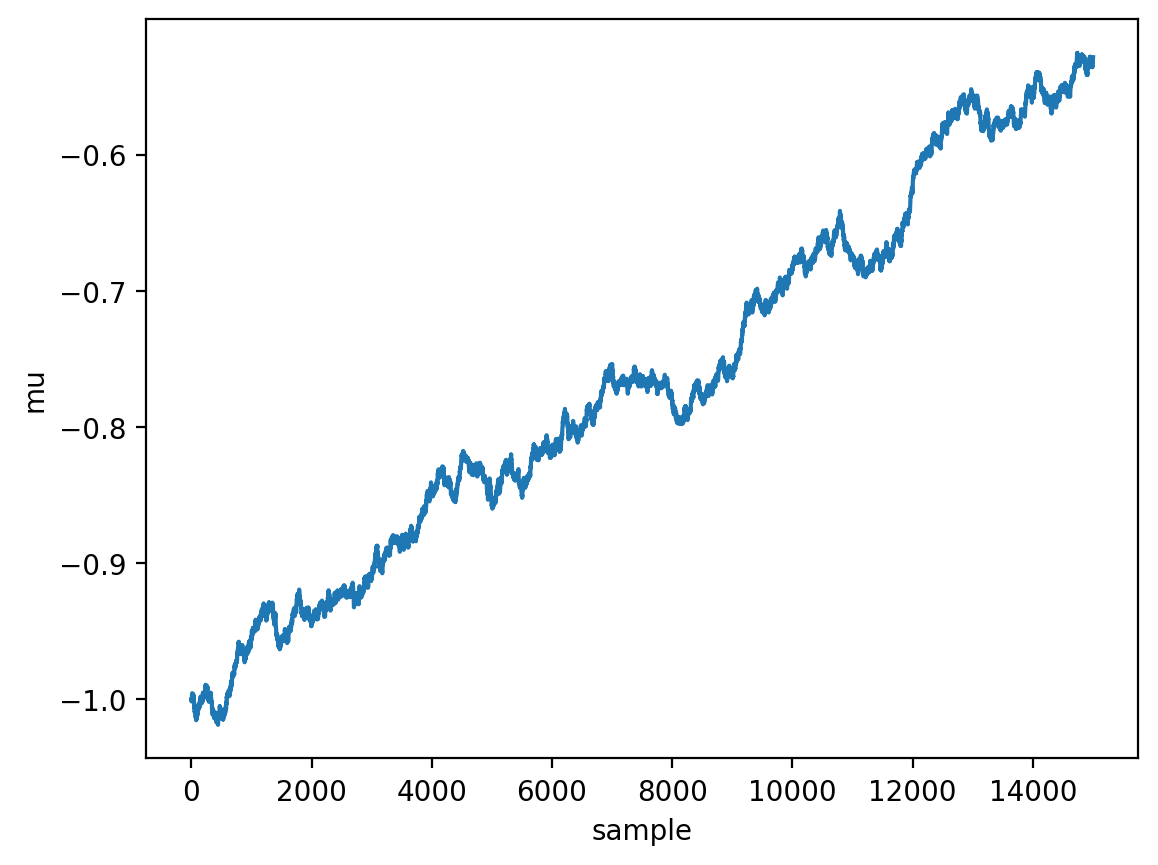

In [17]:
posterior = sampler(data, samples=15000, mu_init=-1., proposal_width=0.001)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

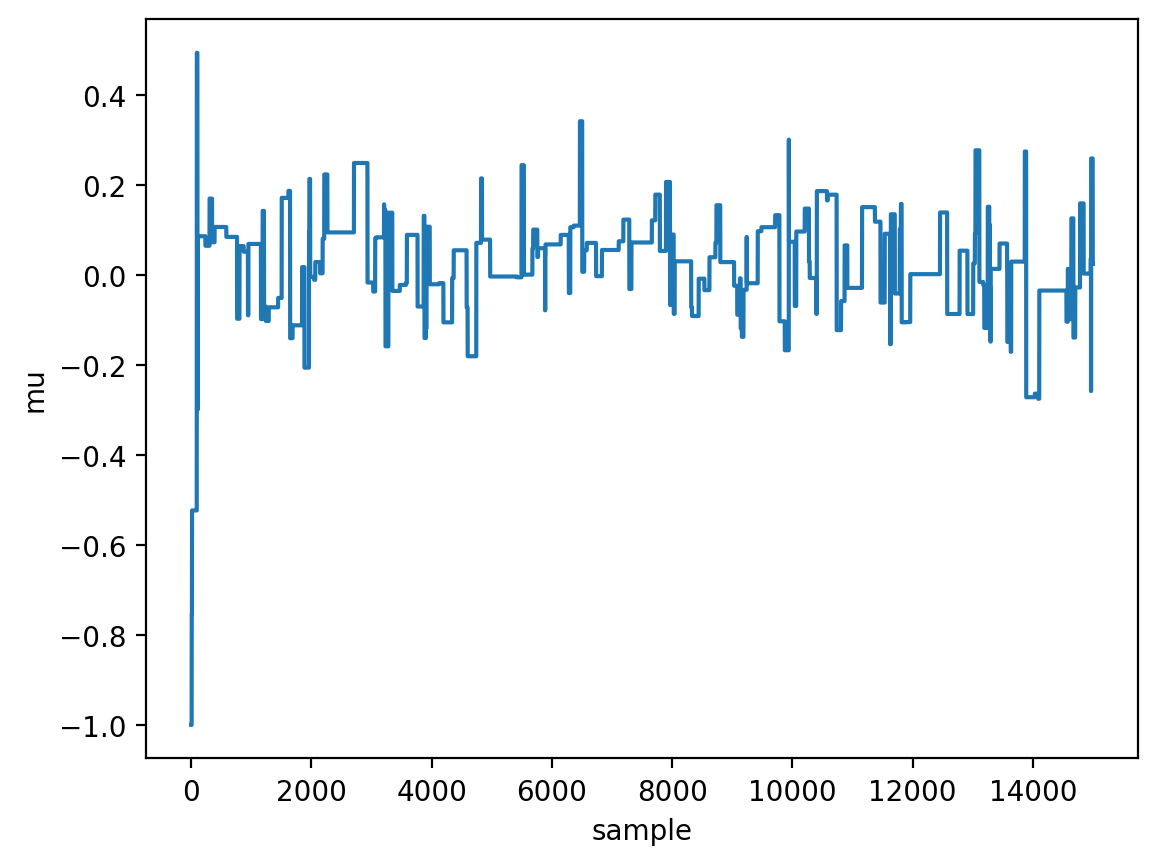

In [22]:
posterior = sampler(data, samples=15000, mu_init=-1., proposal_width=10)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

Ideally, our traceplot in each parameter would be **mixing well** (moving across parameter space without getting stuck), and carving out the same patch of parameter space on average. **The acceptance rate of new samples should be somewhere between $\sim20-50\%$ depending on the type of problem you're trying to solve**.

Take a look at these plots below for an arbitrary problem. The 1st column is the trace, the 2nd is the histogram of the chain, and the 3rd column is the acceptance rate of newly proposed samples. 

- **In the top row, the proposal width was too small**. The chain hardly moves, giving it a high acceptance rate but poor global exploration of the posterior surface.
- **In the middle row, the proposal width was too big**. The chain proposes new points that are far away from regions of high probability density, meaning that they're hardly ever accepted. The chain gets stuck.
- **Only the bottom row shows reasonable sampling. This is the Goldilocks scenario.**

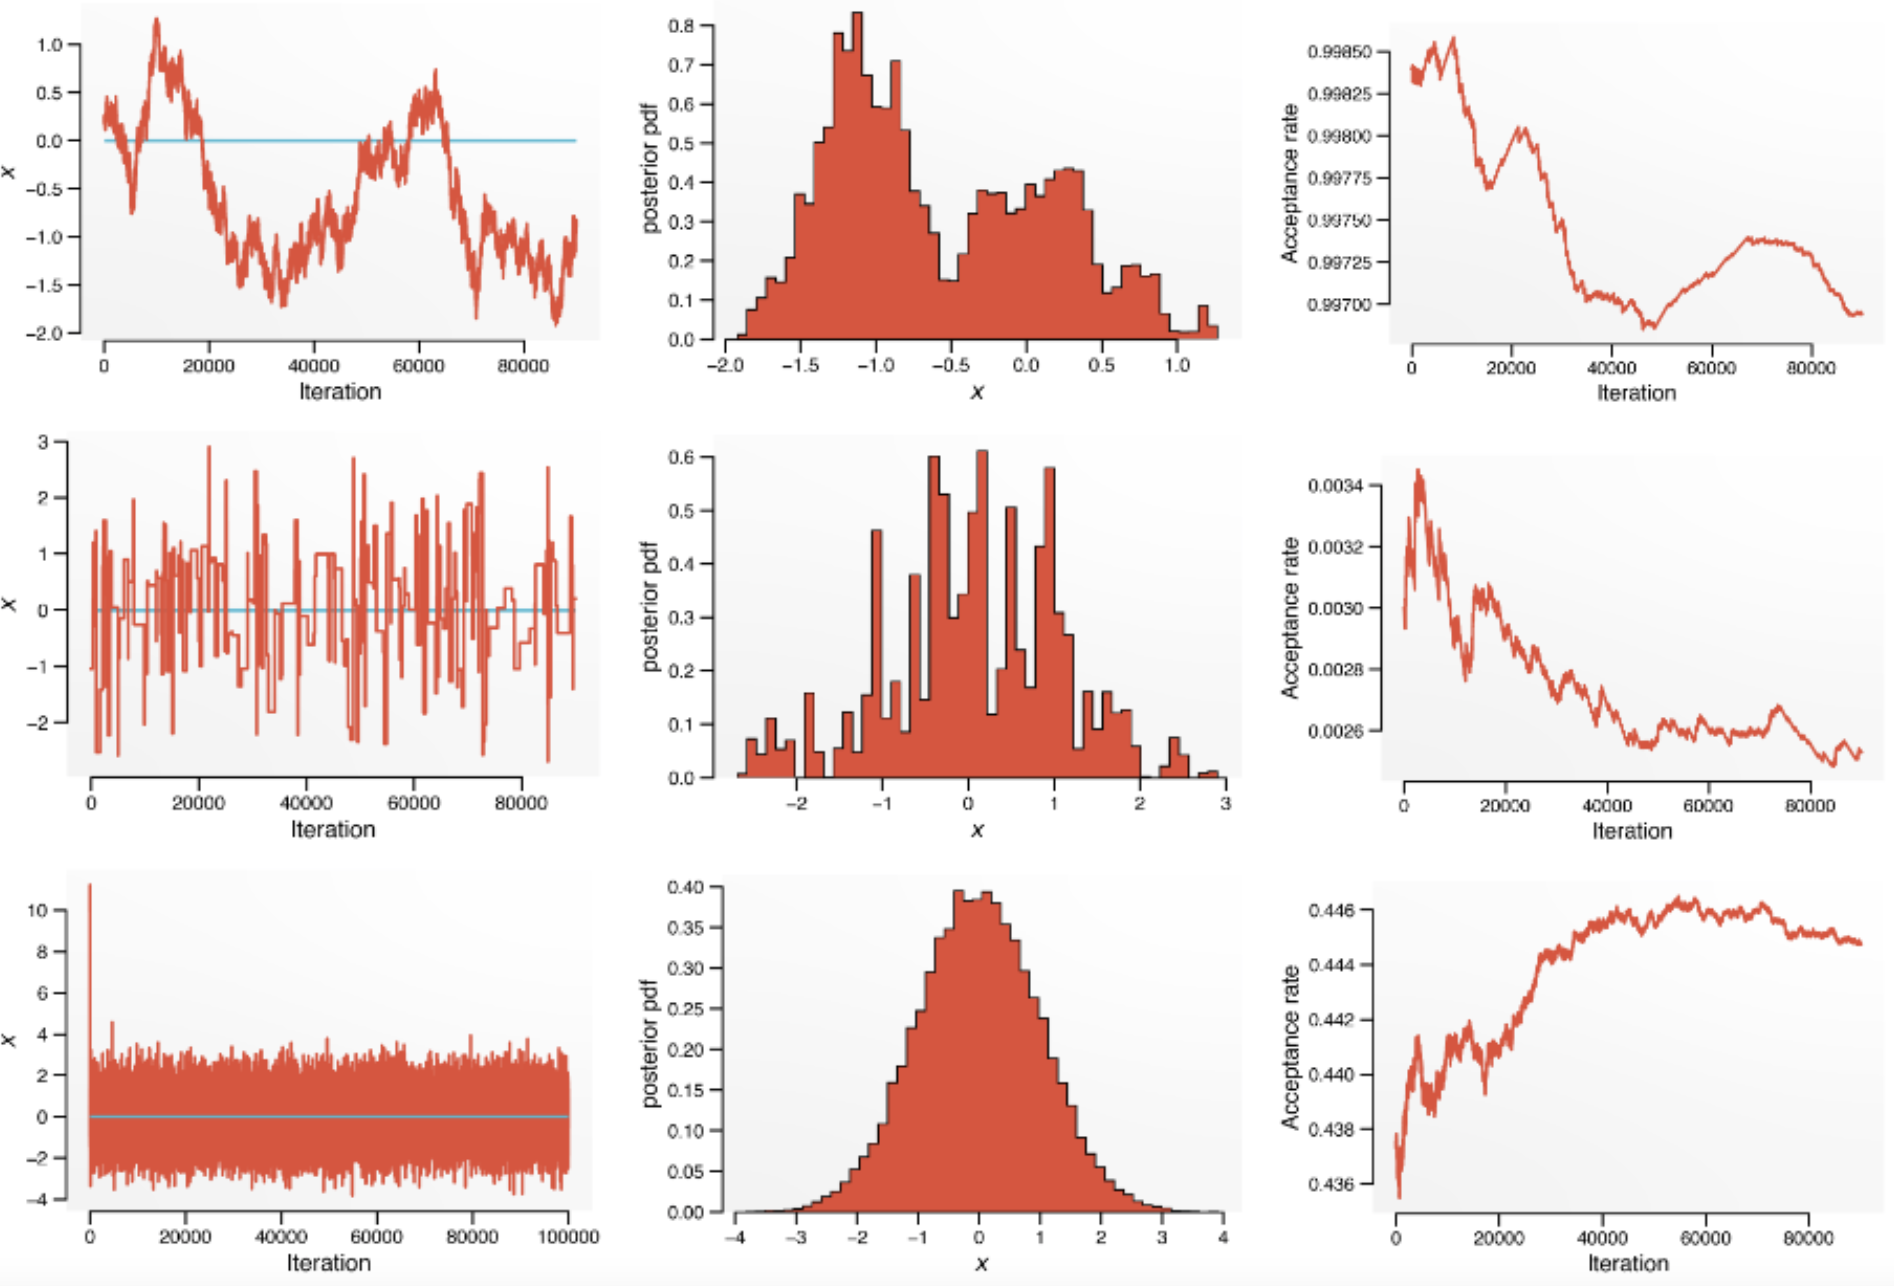

---

## Very important

Note that MCMC does not give you the value of the pdf on a grid: **all you have are the samples!**

Crucially, the **density** of samples is proportional to the posterior. So running a density estimation tool (histogram, KDE, etc) on those returns the  pdf you're looking for.

---

### More Complex Models & Sophisticated Sampling

- The example you worked through above was overkill in that we were only trying to estmate $\mu$. Note also that we can do this in fewer than 10 lines using something like ${\tt emcee}$ or ${\tt pymc3}$ (next time!).

- The process is essentially the same when you add more parameters. Check out this [animation of a 2-D process](http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/) by the same author whose example we just followed.

- Also, check out [this](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=AdaptiveMH&target=multimodal) amazing visualization tool, and have some fun exploring the many different types of sampling algorithms. Metropolis-Hastings is only the start! (please take a look at all the different samplers and how they sample different distributions). 

- In fact, the most basic type of MH algorithm I would ever personally use is **Adaptive Metropolis-Hastings**, where the proposal width updates itself in response to the currently-estimate covariance matrix of the MCMC chain (i.e. the chain learns how to optimize itself).

- In practice, MH is too simple for current problems. We'll look at other algorithms and samplers next time. There are plenty of tools that a professional (astro)physicist can have in their toolbox to tackle research problems.

>## Assignment: A detector data-quality Markov chains

You are analyzing data from a particle-physics experiment. In practice, the detector does
not behave identically all the time: it switches between a **Good** state (stable,
low noise, well-calibrated) and a **Bad** state (high noise, unstable baseline, or
temporary hardware issues).

A possible feature of real data-taking is that conditions are **time-correlated**:
the probability of being in a given state tomorrow depends on the state today
(e.g. electronics stability, temperature drift, background environment).

From historical monitoring, you estimate the transition probabilities:

$$
p({\rm Good\ tomorrow}\mid{\rm Bad\ today}) = 0.5,
\qquad
p({\rm Bad\ tomorrow}\mid{\rm Bad\ today}) = 0.5,
$$

$$
p({\rm Bad\ tomorrow}\mid{\rm Good\ today}) = 0.1,
\qquad
p({\rm Good\ tomorrow}\mid{\rm Good\ today}) = 0.9.
$$

It is often convenient to write these in matrix form. If we order the states as
$$({\rm Good}, {\rm Bad}),$$
then the transition matrix is

$$
T =
\begin{pmatrix}
p({\rm Good}\to{\rm Good}) & p({\rm Good}\to{\rm Bad}) \\
p({\rm Bad}\to{\rm Good}) & p({\rm Bad}\to{\rm Bad})
\end{pmatrix}
=
\begin{pmatrix}
0.9 & 0.1 \\
0.5 & 0.5
\end{pmatrix}.
$$

If we simulate this chain for many days, the fraction of time spent in each state
approaches a **stationary distribution** (an equilibrium duty cycle)

$$
p({\rm Good}) \approx 0.83,
\qquad
p({\rm Bad}) \approx 0.17.
$$

Interpretation: in the long run, roughly 83% of days are expected to be “Good data-taking”
days under this simple model.

---

#### Tasks

1. **Initialize** the system in the **Bad** state on day 0.

2. **Simulate** the Markov chain forward for $N$ days (use $N \gtrsim 10^4$).

3. Make a **trace plot** showing how your estimate of $p({\rm Good})$ stabilizes with time:
   - x-axis: day number $N$  
   - y-axis: the cumulative fraction of Good days

$$
\widehat{p}_N({\rm Good}) = \frac{\#\{\text{Good days among the first }N\text{ days}\}}{N}.
$$

4. Make a **histogram of estimates** of $p({\rm Good})$.  
   A practical way to do this is to split the chain into blocks of equal length
   (e.g. 50 or 100 days per block), compute $$\widehat{p}({\rm Good})$$ in each block,
   and then histogram the block estimates.  
   (This gives a sensible empirical distribution for the estimator.)

5. Use **summary statistics** to quote:
   - a point estimate for $p({\rm Good})$ (mean or median of the block estimates),
   - an uncertainty (e.g. standard deviation of the block estimates, or a 68% interval).

---

#### Burn-in and stationarity

In MCMC, the chain must be **stationary**, meaning its statistical properties look the same
no matter which part of the chain you examine. This is usually not true at the beginning if
we start from an atypical state (like Bad).

6. Experiment with discarding different numbers of initial days as **burn-in**.
   For several choices of $N_{\rm burn}$, recompute your trace plot and your estimate of
   $p({\rm Good})$. How sensitive are your results to burn-in?

**Hint:** Always start by looking at the trace plot. If the trace has not stabilized,
you are not yet sampling the stationary regime.

>## Solution

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
#define a transition matrix for a simple 2-state Markov chain:
T = np.array([
    [0.9, 0.1],  # from Good
    [0.5, 0.5]   # from Bad
])
#number of time steps
N = 1000_000
#initialize state array
state = np.empty(N, dtype=int)

# define states
BAD = 1
GOOD = 0

# initial state
state[0] = BAD  # start from Bad day
# set random seed for reproducibility
rng = np.random.default_rng(123)

#simulate the Markov chain
for t in range(N - 1):
    current = state[t]
    # draw next state according to the transition probabilities of current state
    # we can use rng.choice to select next state based on probabilities. 
    state[t + 1] = rng.choice([GOOD, BAD], p=T[current])

In [59]:
# we can now estimate the long-term fraction of good days. Here astype(int) converts boolean to integer (1 for True, 0 for False). So if state[t] == GOOD, we get 1, else 0.
is_good = (state == GOOD).astype(int)
# cumulative sum of good days
cum_good = np.cumsum(is_good)
# array of days
days = np.arange(1, N + 1)

p_hat = cum_good / days

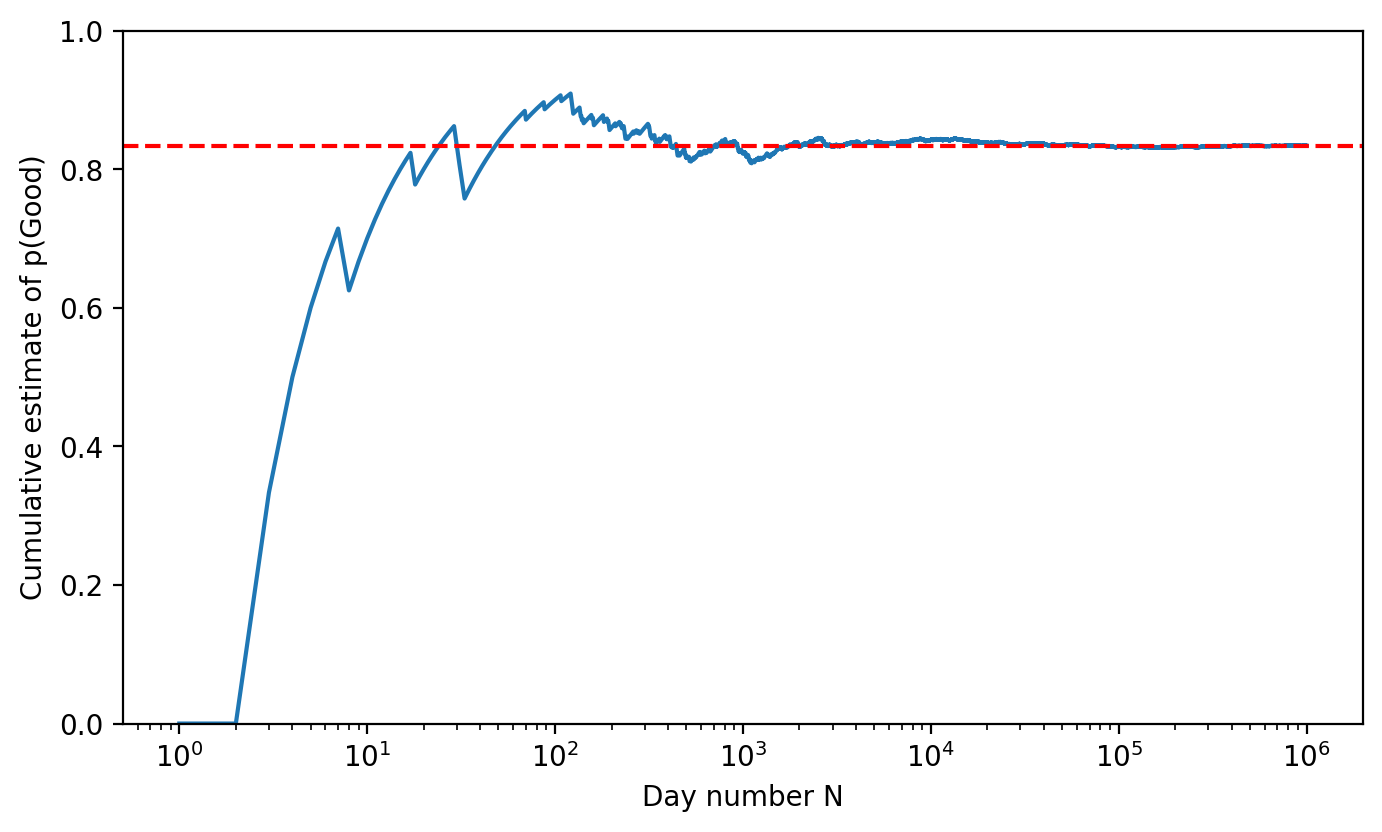

In [60]:
plt.figure(figsize=(8, 4.5))
# let us plot log scale on x-axis to see convergence better
plt.xscale('log')
plt.plot(days, p_hat)
#draw a dashed line at the true long-term probability of good days
plt.axhline(0.8333, color='red', linestyle='--', label='True p(Good)=5/6')
plt.xlabel("Day number N")
plt.ylabel("Cumulative estimate of p(Good)")
plt.ylim(0, 1)
plt.show()

So indeed we see the curve stabalizes around 0.83. As you can see, there is also quite a significant burn-in. 

In [79]:
#Next, we discard the first N_burn samples as burn-in:
N_burn = 500000
state_post = state[N_burn:]


In [86]:
# Now, # we can use the blocking method to estimate the uncertainty. 
B = 200  # block length in days
M = len(state_post) // B  # number of full blocks. The // makes this an integer division

# reshape the data into M blocks of length B
trimmed = state_post[:M * B]
# block shape is (M, B)
blocks = trimmed.reshape(M, B)

block_phat = (blocks == GOOD).mean(axis=1)

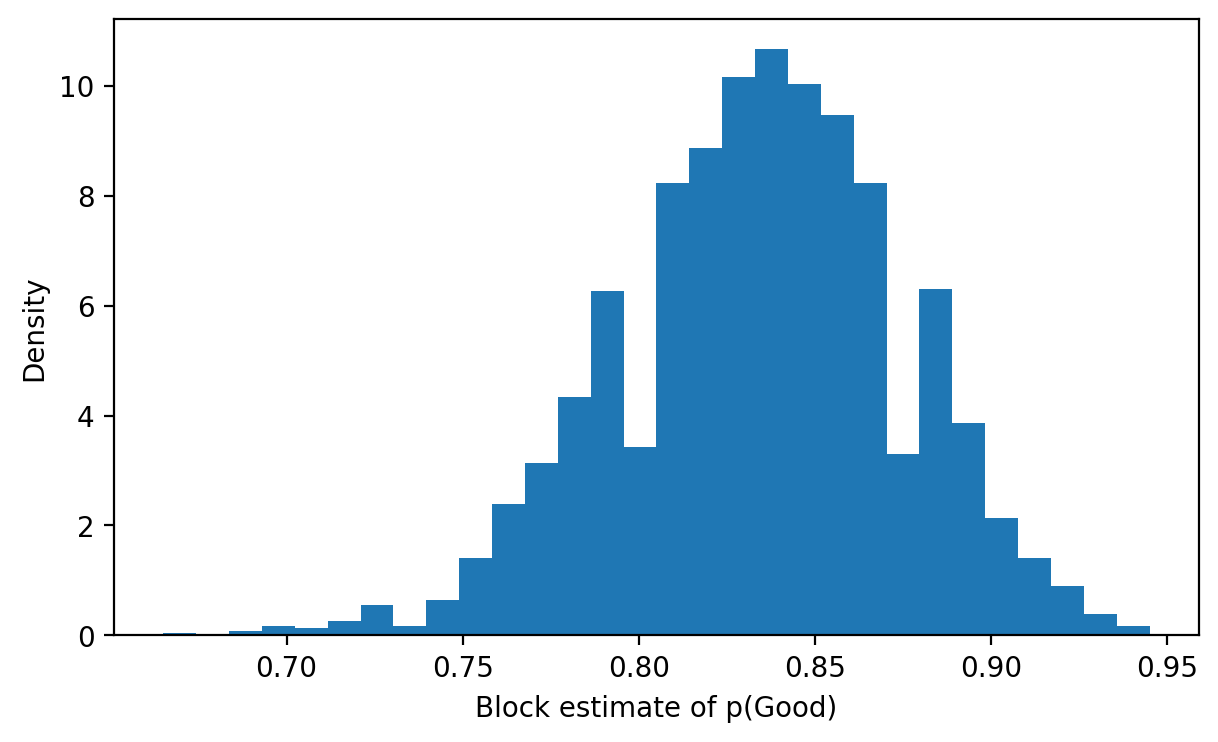

In [87]:
plt.figure(figsize=(7, 4))
plt.hist(block_phat, bins=30, density=True)
plt.xlabel("Block estimate of p(Good)")
plt.ylabel("Density")
plt.show()

In [73]:
# Final estimate and uncertainty
p_est = block_phat.mean()
p_err = block_phat.std(ddof=1)

In [74]:
# 68% credible interval from percentiles
low, high = np.percentile(block_phat, [16, 84])

In [75]:
print(f"Estimated p(Good) = {p_est:.4f} ± {p_err:.4f} (block std, B={B})")
print(f"68% interval (block-based) = [{low:.4f}, {high:.4f}]")

Estimated p(Good) = 0.8339 ± 0.0402 (block std, B=200)
68% interval (block-based) = [0.7950, 0.8750]


In [78]:
burn_values = [10,100,1000,10000, 50000, 100000, 200000]
B = 200

for N_burn in burn_values:
    state_post = state[N_burn:]
    M = len(state_post) // B
    trimmed = state_post[:M * B]
    blocks = trimmed.reshape(M, B)
    block_phat = (blocks == GOOD).mean(axis=1)
    p_est = block_phat.mean()
    p_err = block_phat.std(ddof=1)
    print(f"N_burn={N_burn:5d} -> p(Good) = {p_est:.4f} ± {p_err:.4f}")

N_burn=   10 -> p(Good) = 0.8337 ± 0.0401
N_burn=  100 -> p(Good) = 0.8337 ± 0.0408
N_burn= 1000 -> p(Good) = 0.8337 ± 0.0402
N_burn=10000 -> p(Good) = 0.8336 ± 0.0403
N_burn=50000 -> p(Good) = 0.8336 ± 0.0403
N_burn=100000 -> p(Good) = 0.8339 ± 0.0402
N_burn=200000 -> p(Good) = 0.8342 ± 0.0401


## Bonus 
A Markov chain with transition matrix $T$ has a **stationary distribution**
$\boldsymbol{\pi}$ if

$$
\boldsymbol{\pi} = \boldsymbol{\pi} \, T,
$$

with the normalization condition

$$
\sum_i \pi_i = 1.
$$

This equation means that if the system is distributed according to
$\boldsymbol{\pi}$ today, it will have the **same distribution tomorrow**.
In other words, $\boldsymbol{\pi}$ is an equilibrium distribution.

The condition

$$
\boldsymbol{\pi} = \boldsymbol{\pi} \, T
$$

can be rewritten as

$$
T^\mathsf{T} \boldsymbol{\pi}^\mathsf{T} = \boldsymbol{\pi}^\mathsf{T}.
$$

This shows that the stationary distribution is a **left eigenvector** of $T$
(or equivalently, a right eigenvector of $T^\mathsf{T}$) with **eigenvalue 1**.

This is guaranteed to exist for any valid transition matrix because:
- all rows of $T$ sum to 1,
- $T$ is a stochastic matrix,
- stochastic matrices always have an eigenvalue equal to 1.


In [89]:
# left eigenvector of T with eigenvalue 1 (as required for steady-state distribution)
eigvals, eigvecs = np.linalg.eig(T.T)
# index of eigenvalue closest to 1
i = np.argmin(np.abs(eigvals - 1))
# extract corresponding eigenvector
pi = eigvecs[:, i].real
# normalize to sum to 1
pi = pi / pi.sum()
# print the probabilities of each state
print(f"Steady-state distribution: p(Good)={pi[GOOD]:.4f}, p(Bad)={pi[BAD]:.4f}")

Steady-state distribution: p(Good)=0.8333, p(Bad)=0.1667


Note that the original question concerned sunny and rainy weather days for observation planning. The solution that was drafted by Davide is given [here](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/solutions/S08_cloudyorsunny.ipynb). 